In [1]:
import os
import numpy as np
import pandas as pd
from itertools import cycle
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, fbeta_score, accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
#     Evaluation Metrics
from itertools import cycle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from scipy import stats


def roc_auc_plot(y_true, y_pred,
                 n_classes=2, lw=2, data_title='Unspecified',
                 save_fig=True, fig_dir=r'/data/maia/mdohop/Holman_Pathway/Feeding_Tube/Models/Figures'):
    """
    plot ROC and compute auc using sklearn. Taken from https://github.com/Tony607/ROC-Keras/blob/master/ROC-Keras.ipynb.
    :param y_true: ground truth
    :param y_pred: prediction
    :param n_classes: number of classes
    :param lw: line width
    :param data_title: title of the figure
    :param save_fig: True/False; If True then saves the figure to fig_dir
    :param fig_dir: directory of the saved figure
    :return:
    """

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes
    # print(np.shape(fpr["micro"]))

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    yo_index = (1 - fpr['macro']) + 1.0*tpr['macro'] - 1
    # print('youden index al')
    # print(yo_index)
    # print(np.max(yo_index))
    index_max = np.argmax(yo_index)
    # print(np.argmax(index_max))
    yo_sensitivity = tpr['macro'][index_max]
    yo_specificity = 1-fpr['macro'][index_max]
    # print(f"max youden index sensitivity: {tpr['macro'][index_max]}")
    # print(f"max youden index specificity: {1-fpr['macro'][index_max]}")
    # print('')

    # Plot all ROC curves
    plt.figure(1)
    i = 1
    plt.plot(fpr[i], tpr[i], color='cornflowerblue', lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC--{data_title}")
    plt.legend(loc="lower right")

    if save_fig:
        os.chdir(fig_dir)
        plt.savefig(f"ROC--{data_title}")

    plt.show()
    plt.clf()

    return yo_sensitivity, yo_specificity


def sensivity_specifity_cutoff(y_true, y_score):
    '''Find data-driven cut-off for classification

    Cut-off is determined using Youden's index defined as sensitivity + specificity - 1.

    Parameters
    ----------

    y_true : array, shape = [n_samples]
        True binary labels.

    y_score : array, shape = [n_samples]
        Target scores, can either be probability estimates of the positive class,
        confidence values, or non-thresholded measure of decisions (as returned by
        “decision_function” on some classifiers).

    References
    ----------

    Ewald, B. (2006). Post hoc choice of cut points introduced bias to diagnostic research.
    Journal of clinical epidemiology, 59(8), 798-801.

    Steyerberg, E.W., Van Calster, B., & Pencina, M.J. (2011). Performance measures for
    prediction models and markers: evaluation of predictions and classifications.
    Revista Espanola de Cardiologia (English Edition), 64(9), 788-794.

    Jiménez-Valverde, A., & Lobo, J.M. (2007). Threshold criteria for conversion of probability
    of species presence to either–or presence–absence. Acta oecologica, 31(3), 361-369.
    '''
    fpr, tpr, thresholds = roc_curve(y_true, y_score, drop_intermediate=True)
    # increasing significance of sensitivity
    idx = np.argmax(1.0*tpr - fpr)
    return thresholds[idx], thresholds



In [3]:
import pandas as pd
import numpy as np
import scipy.stats

# AUC comparison adapted from
# https://github.com/Netflix/vmaf/


def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5 * (i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Operating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    log_10 = np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)
    return {'log10': log_10, 'p-value': 10 ** log_10}


def compute_ground_truth_statistics(ground_truth):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    return order, label_1_count


def delong_roc_variance(ground_truth, predictions):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


def delong_roc_test(ground_truth, predictions_one, predictions_two):
    """
    Computes log(p-value) for hypothesis that two ROC AUCs are different
    Args:
       ground_truth: np.array of 0 and 1
       predictions_one: predictions of the first model,
          np.array of floats of the probability of being class 1
       predictions_two: predictions of the second model,
          np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    return calc_pvalue(aucs, delongcov)


def delong_roc_curve_analysis(y_true=None, y_pred=None, alpha_ci=0.95):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    assert len(y_pred) == len(y_true), f"pred and label should be same length; {len(y_pred)}, {len(y_true)}"
    assert 0 < alpha_ci < 1.00, f"alpha_ci should be between 0 and 1"

    alpha = alpha_ci

    auc, auc_cov = delong_roc_variance(
        y_true,
        y_pred)

    auc_std = np.sqrt(auc_cov)
    lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

    ci = stats.norm.ppf(
        lower_upper_q,
        loc=auc,
        scale=auc_std)

    ci[ci > 1] = 1

#     print('AUC:', auc)
#     print('AUC COV:', auc_cov)
#     print(f"{alpha * 100}%_ci:", ci)
#     print('')

    return {'auc': auc, f"{alpha * 100}%_ci": ci, 'auc_std': auc_std, 'auc_cov': auc_cov}

In [4]:
def roc_auc_plot_changed(y_true, y_pred,
                 n_classes=2, lw=2, data_title='Unspecified',
                 save_fig=False, fig_dir=r'/data/maia/mdohop/Holman_Pathway/Feeding_Tube/Models/Figures'):
    """
    plot ROC and compute auc using sklearn. Taken from https://github.com/Tony607/ROC-Keras/blob/master/ROC-Keras.ipynb.
    :param y_true: ground truth
    :param y_pred: prediction
    :param n_classes: number of classes
    :param lw: line width
    :param data_title: title of the figure
    :param save_fig: True/False; If True then saves the figure to fig_dir
    :param fig_dir: directory of the saved figure
    :return:
    """

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:], y_pred[:])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true, y_pred)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    yo_index = (1 - fpr['macro']) + 1.0*tpr['macro'] - 1
    # print('youden index al')
    # print(yo_index)
    # print(np.max(yo_index))
    index_max = np.argmax(yo_index)
    # print(np.argmax(index_max))
    yo_sensitivity = tpr['macro'][index_max]
    yo_specificity = 1-fpr['macro'][index_max]
    print(f"max youden index sensitivity: {tpr['macro'][index_max]}")
    print(f"max youden index specificity: {1-fpr['macro'][index_max]}")
    print('')

    # Plot all ROC curves
    plt.figure(1)
    i = 1
    plt.plot(fpr[i], tpr[i], color='cornflowerblue', lw=lw,
             label='ROC curve {0} (area = {1:0.2f})'
                   ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC--{data_title}")
    plt.legend(loc="lower right")

    return fpr[i], tpr[i]


def dr_friendly_measures(y_true, y_pred):
    """
    :param y_true: ground truth
    :param y_pred: prediction
    :return: specificity, sensitivity, ppv, npv
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    true_values = pd.DataFrame(y_true).rename(columns={0: 'true'})

    specificity = tn / (tn + fp + 1e-8)
    sensitivity = tp / (tp + fn + 1e-8)
    ppv = tp / (tp + fp + 1e-8)
    npv = tn / (tn + fn + 1e-8)

    name1 = ['specificity', 'sensitivity', 'ppv', 'npv']
    name2 = [specificity, sensitivity, ppv, npv]

#     for i in range(len(name1)):
#         print(f"{name1[i]}: {np.round(name2[i], 3)}")

    return specificity, sensitivity, ppv, npv

def outcome_add(y_true, y_pred, y_pred_final, *args, **kwargs):
    """
    :param y_true: ground truth
    :param y_pred: prediction
    :return: specificity, sensitivity, ppv, npv
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_final).ravel()
    specificity = tn / (tn + fp + 1e-8)
    sensitivity = tp / (tp + fn + 1e-8)
    ppv = tp / (tp + fp + 1e-8)
    npv = tn / (tn + fn + 1e-8)
    
    
    from sklearn.metrics import roc_auc_score
    try:
        auc = roc_auc_score(y_true=y_true, y_score=y_pred)
    except:
        auc = np.nan
    
    return sensitivity, specificity, ppv, npv, auc

def bootstrap_outcome(data, n_iter=9999, size=0.90, conf_int=0.95):
    print('PERFORMING BOOTSTRAP')
    from sklearn.utils import resample
    import numpy as np
    
    n_size = int(len(data)*size)
    
    sens_list = []
    spec_list = []
    npv_list = []
    ppv_list = []
    auc_list = []
    
    for i in range(n_iter):
        # prepare train and test sets
        resample_data = resample(data, n_samples=n_size)
        sens, spec, ppv, npv, auc = outcome_add(y_true=resample_data['true'], 
                                                y_pred=resample_data['pred'],
                                                y_pred_final=resample_data['pred_final'])
        
        sens_list.append(sens)
        spec_list.append(spec)
        npv_list.append(npv)
        ppv_list.append(ppv)
        auc_list.append(auc)
    
    stats_dict = {}
    
    for stats in [(sens_list, 'sensitivity'), (spec_list, 'specificity'), (npv_list, 'npv'), (ppv_list, 'ppv'), (auc_list, 'auc')]: 
        p = ((1.0-conf_int)/2.0) * 100
        lower = max(0.0, np.percentile(stats[0], p))
        p = (conf_int+((1.0-conf_int)/2.0)) * 100
        upper = min(1.0, np.percentile(stats[0], p))
        
        stats_dict [stats[1]] = np.array([lower, upper])

    return stats_dict

In [5]:
csv_dir = r'C:\Users\s185479\Desktop\Python_Code\Projects\Feeding_Tube\uncertainty\quick_uncertainty_extraction'

def simple_threshold(x, thres=0.5):
    if x >= thres:
        return 1
    else:
        return 0
    
def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])[0]


cut_off_percent_list = list(np.arange(40, 90, 5))
cut_range = cut_off_percent_list
min_cut = cut_range[0]
bootstrap_ = True
auc_off = True # dont need bootstrap for auc
conf_int = 0.95
std_num = 1

dict_ = {'all':{}}

for i in range(5):
    dict_['all'].update({f"model_{i}":{}})

    for c in cut_off_percent_list:
        dict_['all'][f"model_{i}"].update({f"c_{c}": {'total_pred_df': None, 'h_uncert_df': None, 'l_uncert_df': None, 
                                                            'total_AUC': None, 'h_AUC': None, 'l_AUC': None, 
                                                            'total_acc': None, 'l_acc': None, 'h_acc': None,
                                                            'total_prauc': None, 'l_prauc': None, 'h_prauc': None,
                                                            'total_sens': None, 'l_sens': None, 'h_sens': None,
                                                            'total_spec': None, 'l_spec': None, 'h_spec': None}})


for mt in ['image']:
    for m in ['val', 'test']:
#         for s in [50, 100, 150, 200]:
        for s in [200]:

            test_filename_do = \
            [f"{mt}_model_{m}_epistemic_do_entropy_resnet_50_epoch_120_batch_end_fold_1_bottleneck_0.0_0.05_downsample_1.0_0.05_num300_rundate_2022.01.25.csv", 
             f"{mt}_model_{m}_epistemic_do_entropy_resnet_50_epoch_120_batch_end_fold_2_bottleneck_0.0_0.05_downsample_1.0_0.05_num300_rundate_2022.01.25.csv",
             f"{mt}_model_{m}_epistemic_do_entropy_resnet_50_epoch_120_batch_end_fold_3_bottleneck_0.0_0.05_downsample_1.0_0.05_num300_rundate_2022.01.25.csv",
             f"{mt}_model_{m}_epistemic_do_entropy_resnet_50_epoch_120_batch_end_fold_4_bottleneck_0.0_0.05_downsample_1.0_0.05_num300_rundate_2022.01.25.csv", 
             f"{mt}_model_{m}_epistemic_do_entropy_resnet_50_epoch_120_batch_end_fold_5_bottleneck_0.0_0.05_downsample_1.0_0.05_num300_rundate_2022.01.25.csv"]
            
            test_filename_tta = \
            [f"{mt}_model_{m}_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_1_num300_ttafactor_3.0_rundate_2022.01.25.csv", 
             f"{mt}_model_{m}_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_2_num300_ttafactor_3.0_rundate_2022.01.25.csv",
             f"{mt}_model_{m}_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_3_num300_ttafactor_3.0_rundate_2022.01.25.csv",
             f"{mt}_model_{m}_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_4_num300_ttafactor_3.0_rundate_2022.01.25.csv",
             f"{mt}_model_{m}_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_5_num300_ttafactor_3.0_rundate_2022.01.25.csv"]
            
            pred_filename_tta = \
            [f"{mt}_model_{m}_epistemic_do_entropy_resnet_50_epoch_120_batch_end_fold_1_bottleneck_0.0_0.05_downsample_1.0_0.05_num300_rundate_2022.01.25.csv", 
             f"{mt}_model_{m}_epistemic_do_entropy_resnet_50_epoch_120_batch_end_fold_2_bottleneck_0.0_0.05_downsample_1.0_0.05_num300_rundate_2022.01.25.csv",
             f"{mt}_model_{m}_epistemic_do_entropy_resnet_50_epoch_120_batch_end_fold_3_bottleneck_0.0_0.05_downsample_1.0_0.05_num300_rundate_2022.01.25.csv",
             f"{mt}_model_{m}_epistemic_do_entropy_resnet_50_epoch_120_batch_end_fold_4_bottleneck_0.0_0.05_downsample_1.0_0.05_num300_rundate_2022.01.25.csv", 
             f"{mt}_model_{m}_epistemic_do_entropy_resnet_50_epoch_120_batch_end_fold_5_bottleneck_0.0_0.05_downsample_1.0_0.05_num300_rundate_2022.01.25.csv"]
            
            test_filename_conf = \
            [f"model_1_signif_0.05_{m}.csv", 
             f"model_2_signif_0.05_{m}.csv",
             f"model_3_signif_0.05_{m}.csv",
             f"model_4_signif_0.05_{m}.csv",
             f"model_5_signif_0.05_{m}.csv"]

            
            df = None
            for i, f in enumerate(test_filename_do):

                do_df = pd.read_csv(os.path.join(csv_dir, test_filename_do[i]))
                do_df['u_do'] = do_df['mean_entropy']
                do_df = do_df.drop(columns=['mean_entropy'])
                tta_df = pd.read_csv(os.path.join(csv_dir, test_filename_tta[i]))
                tta_df['u_tta'] = tta_df['mean_entropy']
                tta_df = tta_df.drop(columns=['mean_entropy'])
                conf_df = pd.read_csv(os.path.join(csv_dir, test_filename_conf[i]))
                

                df = pd.concat([do_df, tta_df, conf_df], axis=1)


                for jj, cut in enumerate(cut_off_percent_list):

                    if m == 'val':
                        val_do_cutoff = np.percentile(df['u_do'], cut)
                        val_tta_cutoff = np.percentile(df['u_tta'], cut)
                        val_conf_cutoff = cut/100
                        optim_val_thresh = Find_Optimal_Cutoff(target=df['y_true'].tolist(), predicted=df['class_1_pred'].tolist())
                        
                    if m == 'val' and i == 0 and jj == 0:
                        save_val_do_list = []
                        save_val_tta_list = []
                        save_val_conf_list = []
                        save_val_thresh_list = []

                        save_val_do_list.append(val_do_cutoff)
                        save_val_tta_list.append(val_tta_cutoff)
                        save_val_conf_list.append(val_conf_cutoff)
                        save_val_thresh_list.append(optim_val_thresh)

                    elif m == 'val':
                        save_val_do_list.append(val_do_cutoff)
                        save_val_tta_list.append(val_tta_cutoff)
                        save_val_conf_list.append(val_conf_cutoff)
                        save_val_thresh_list.append(optim_val_thresh)
                    elif m == 'test':
                        optim_val_thresh = save_val_thresh_list[jj]


                    new_df = df
                    new_df['true'] = new_df['y_true']
                    new_df['pred'] = new_df['class_1_pred']
                    new_df['pred_final'] = new_df['pred'].apply(lambda x: np.where(x>=optim_val_thresh, 1, 0))

    
                    def acc(y_true, y_pred):
                        return np.sum(np.equal(y_true, y_pred)) / len(y_true)
            
            
                    from sklearn.metrics import average_precision_score
                    average = 'weighted'
                    dict_['all'][f"model_{i}"][f"c_{cut}"]['total_AUC'] = roc_auc_score(y_true=new_df['true'], y_score=new_df['pred'])
                    dict_['all'][f"model_{i}"][f"c_{cut}"]['total_prec'] = average_precision_score(y_true=new_df['true'], y_score=new_df['pred'], average=average)
                    dict_['all'][f"model_{i}"][f"c_{cut}"]['total_acc'] = acc(y_true=new_df['true'], y_pred=new_df['pred_final'])
                    dict_['all'][f"model_{i}"][f"c_{cut}"]['total_correct'] = np.sum(new_df['true']==new_df['pred_final'])
                    
                    specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=new_df['true'], y_pred=new_df['pred_final'])
                    
                    dict_['all'][f"model_{i}"][f"c_{cut}"]['total_sens'] = sensitivity
                    dict_['all'][f"model_{i}"][f"c_{cut}"]['total_spec'] = specificity


                    

                    if m == 'test':
                        val_do_cutoff = save_val_do_list[jj]
                        val_tta_cutoff = save_val_tta_list[jj]
                        val_conf_cutoff = save_val_conf_list[jj]


                        # low uncertainty
                        low_uncertainty_df = new_df.loc[(new_df['u_do']<val_do_cutoff) & (new_df['u_tta']<val_tta_cutoff) & (new_df['Credibility']>=1-val_conf_cutoff)]

                        dict_['all'][f"model_{i}"][f"c_{cut}"]['l_uncert_df'] = low_uncertainty_df
                        dict_['all'][f"model_{i}"][f"c_{cut}"]['l_correct'] = np.sum(np.equal(low_uncertainty_df['true'], low_uncertainty_df['pred_final']))
                        dict_['all'][f"model_{i}"][f"c_{cut}"]['l_acc'] = acc(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final'])
                        specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final'])
                        dict_['all'][f"model_{i}"][f"c_{cut}"]['l_sens'] = sensitivity
                        dict_['all'][f"model_{i}"][f"c_{cut}"]['l_spec'] = specificity

                        try:
                            dict_['all'][f"model_{i}"][f"c_{cut}"]['l_AUC'] = roc_auc_score(y_true=low_uncertainty_df['true'], y_score=low_uncertainty_df['pred']) 
                        except ValueError:
                            dict_['all'][f"model_{i}"][f"c_{cut}"]['l_AUC'] = np.nan

                        try:
                            dict_['all'][f"model_{i}"][f"c_{cut}"]['l_prec'] = average_precision_score(y_true=low_uncertainty_df['true'], y_score=low_uncertainty_df['pred'], average=average) 
                        except ValueError:
                            dict_['all'][f"model_{i}"][f"c_{cut}"]['l_prec'] = np.nan



                        #high uncertainty 
                        high_uncertainty_df = new_df.loc[~((new_df['u_do']<val_do_cutoff) & (new_df['u_tta']<val_tta_cutoff) & (new_df['Credibility']>=1-val_conf_cutoff))]
                        
                        assert len(high_uncertainty_df) + len(low_uncertainty_df) >= 54, f"{np.shape(high_uncertainty_df), np.shape(low_uncertainty_df)}"

                        dict_['all'][f"model_{i}"][f"c_{cut}"]['h_uncert_df'] = high_uncertainty_df
                        dict_['all'][f"model_{i}"][f"c_{cut}"]['h_correct'] = np.sum(np.equal(high_uncertainty_df['true'], high_uncertainty_df['pred_final']))
                        dict_['all'][f"model_{i}"][f"c_{cut}"]['h_acc'] = acc(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final'])
                        specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final'])
                        dict_['all'][f"model_{i}"][f"c_{cut}"]['h_sens'] = sensitivity
                        dict_['all'][f"model_{i}"][f"c_{cut}"]['h_spec'] = specificity

                        try:
                            dict_['all'][f"model_{i}"][f"c_{cut}"]['h_AUC'] = roc_auc_score(y_true=high_uncertainty_df['true'], y_score=high_uncertainty_df['pred'])
                        except ValueError:
                            dict_['all'][f"model_{i}"][f"c_{cut}"]['h_AUC'] = np.nan

                        try:
                            dict_['all'][f"model_{i}"][f"c_{cut}"]['h_prec'] = average_precision_score(y_true=high_uncertainty_df['true'], y_score=high_uncertainty_df['pred'], average=average)
                        except ValueError:
                            dict_['all'][f"model_{i}"][f"c_{cut}"]['h_prec'] = np.nan
                        
print('\n')
print('*'*80)
print('done')            



********************************************************************************
done


In [6]:
# validation

csv_dir = r'C:\Users\s185479\Desktop\Python_Code\Projects\Feeding_Tube\uncertainty\quick_uncertainty_extraction'

def simple_threshold(x, thres=0.5):
    if x >= thres:
        return 1
    else:
        return 0


# cut_off_percent_list = list(np.arange(40, 90, 1))
dict_val = {'all':{}}

for i in range(5):
    dict_val['all'].update({f"model_{i}":{}})

    for c in cut_off_percent_list:
        dict_val['all'][f"model_{i}"].update({f"c_{c}": {'total_pred_df': None, 'h_uncert_df': None, 'l_uncert_df': None, 
                                                            'total_AUC': None, 'h_AUC': None, 'l_AUC': None, 
                                                            'total_acc': None, 'l_acc': None, 'h_acc': None,
                                                            'total_prauc': None, 'l_prauc': None, 'h_prauc': None,
                                                            'total_sens': None, 'l_sens': None, 'h_sens': None,
                                                            'total_spec': None, 'l_spec': None, 'h_spec': None}})


for mt in ['image']:
    for m in ['val', 'test']:
#         for s in [50, 100, 150, 200]:
        for s in [200]:

            test_filename_do = \
            [f"{mt}_model_{m}_epistemic_do_entropy_resnet_50_epoch_120_batch_end_fold_1_bottleneck_0.0_0.05_downsample_1.0_0.05_num300_rundate_2022.01.25.csv", 
             f"{mt}_model_{m}_epistemic_do_entropy_resnet_50_epoch_120_batch_end_fold_2_bottleneck_0.0_0.05_downsample_1.0_0.05_num300_rundate_2022.01.25.csv",
             f"{mt}_model_{m}_epistemic_do_entropy_resnet_50_epoch_120_batch_end_fold_3_bottleneck_0.0_0.05_downsample_1.0_0.05_num300_rundate_2022.01.25.csv",
             f"{mt}_model_{m}_epistemic_do_entropy_resnet_50_epoch_120_batch_end_fold_4_bottleneck_0.0_0.05_downsample_1.0_0.05_num300_rundate_2022.01.25.csv", 
             f"{mt}_model_{m}_epistemic_do_entropy_resnet_50_epoch_120_batch_end_fold_5_bottleneck_0.0_0.05_downsample_1.0_0.05_num300_rundate_2022.01.25.csv"]
            
            test_filename_tta = \
            [f"{mt}_model_{m}_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_1_num300_ttafactor_3.0_rundate_2022.01.25.csv", 
             f"{mt}_model_{m}_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_2_num300_ttafactor_3.0_rundate_2022.01.25.csv",
             f"{mt}_model_{m}_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_3_num300_ttafactor_3.0_rundate_2022.01.25.csv",
             f"{mt}_model_{m}_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_4_num300_ttafactor_3.0_rundate_2022.01.25.csv",
             f"{mt}_model_{m}_aleatoric_tta_entropy_resnet_50_epoch_120_batch_end_fold_5_num300_ttafactor_3.0_rundate_2022.01.25.csv"]
            
            pred_filename_tta = \
            [f"{mt}_model_{m}_epistemic_do_entropy_resnet_50_epoch_120_batch_end_fold_1_bottleneck_0.0_0.05_downsample_1.0_0.05_num300_rundate_2022.01.25.csv", 
             f"{mt}_model_{m}_epistemic_do_entropy_resnet_50_epoch_120_batch_end_fold_2_bottleneck_0.0_0.05_downsample_1.0_0.05_num300_rundate_2022.01.25.csv",
             f"{mt}_model_{m}_epistemic_do_entropy_resnet_50_epoch_120_batch_end_fold_3_bottleneck_0.0_0.05_downsample_1.0_0.05_num300_rundate_2022.01.25.csv",
             f"{mt}_model_{m}_epistemic_do_entropy_resnet_50_epoch_120_batch_end_fold_4_bottleneck_0.0_0.05_downsample_1.0_0.05_num300_rundate_2022.01.25.csv", 
             f"{mt}_model_{m}_epistemic_do_entropy_resnet_50_epoch_120_batch_end_fold_5_bottleneck_0.0_0.05_downsample_1.0_0.05_num300_rundate_2022.01.25.csv"]
            
            test_filename_conf = \
            [f"model_1_signif_0.05_{m}.csv", 
             f"model_2_signif_0.05_{m}.csv",
             f"model_3_signif_0.05_{m}.csv",
             f"model_4_signif_0.05_{m}.csv",
             f"model_5_signif_0.05_{m}.csv"]

            
            df = None
            for i, f in enumerate(test_filename_do):

                do_df = pd.read_csv(os.path.join(csv_dir, test_filename_do[i]))
                do_df['u_do'] = do_df['mean_entropy']
                do_df = do_df.drop(columns=['mean_entropy'])
                tta_df = pd.read_csv(os.path.join(csv_dir, test_filename_tta[i]))
                tta_df['u_tta'] = tta_df['mean_entropy']
                tta_df = tta_df.drop(columns=['mean_entropy'])
                conf_df = pd.read_csv(os.path.join(csv_dir, test_filename_conf[i]))
                

                df = pd.concat([do_df, tta_df, conf_df], axis=1)


                for jj, cut in enumerate(cut_off_percent_list):

                    if m == 'val':
                        val_do_cutoff = np.percentile(df['u_do'], cut)
                        val_tta_cutoff = np.percentile(df['u_tta'], cut)
                        val_conf_cutoff = cut/100
                        optim_val_thresh = Find_Optimal_Cutoff(target=df['y_true'].tolist(), predicted=df['class_1_pred'].tolist())


                    new_df = df
                    new_df['true'] = new_df['y_true']
                    new_df['pred'] = new_df['class_1_pred']
                    new_df['pred_final'] = new_df['pred'].apply(lambda x: np.where(x>=optim_val_thresh, 1, 0))

    
                    def acc(y_true, y_pred):
                        return np.sum(np.equal(y_true, y_pred)) / len(y_true)
            
            
                    from sklearn.metrics import average_precision_score
                    average = 'weighted'
                    dict_val['all'][f"model_{i}"][f"c_{cut}"]['total_AUC'] = roc_auc_score(y_true=new_df['true'], y_score=new_df['pred'])
                    dict_val['all'][f"model_{i}"][f"c_{cut}"]['total_prec'] = average_precision_score(y_true=new_df['true'], y_score=new_df['pred'], average=average)
                    dict_val['all'][f"model_{i}"][f"c_{cut}"]['total_acc'] = acc(y_true=new_df['true'], y_pred=new_df['pred_final'])
                    dict_val['all'][f"model_{i}"][f"c_{cut}"]['total_correct'] = np.sum(new_df['true']==new_df['pred_final'])
                    
                    specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=new_df['true'], y_pred=new_df['pred_final'])
                    
                    dict_val['all'][f"model_{i}"][f"c_{cut}"]['total_sens'] = sensitivity
                    dict_val['all'][f"model_{i}"][f"c_{cut}"]['total_spec'] = specificity


                    if m == 'val':
                        # low uncertainty
                        low_uncertainty_df = new_df.loc[(new_df['u_do']<val_do_cutoff) & (new_df['u_tta']<val_tta_cutoff) & (new_df['Credibility']>=1-val_conf_cutoff)]

                        dict_val['all'][f"model_{i}"][f"c_{cut}"]['l_uncert_df'] = low_uncertainty_df
#                         print(cut)
#                         print(np.shape(low_uncertainty_df))
                        dict_val['all'][f"model_{i}"][f"c_{cut}"]['l_correct'] = np.sum(np.equal(low_uncertainty_df['true'], low_uncertainty_df['pred_final']))
                        dict_val['all'][f"model_{i}"][f"c_{cut}"]['l_acc'] = acc(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final'])
                        specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final'])
                        dict_val['all'][f"model_{i}"][f"c_{cut}"]['l_sens'] = sensitivity
                        dict_val['all'][f"model_{i}"][f"c_{cut}"]['l_spec'] = specificity

                        try:
                            dict_val['all'][f"model_{i}"][f"c_{cut}"]['l_AUC'] = roc_auc_score(y_true=low_uncertainty_df['true'], y_score=low_uncertainty_df['pred']) 
                        except ValueError:
                            dict_val['all'][f"model_{i}"][f"c_{cut}"]['l_AUC'] = np.nan

                        try:
                            dict_val['all'][f"model_{i}"][f"c_{cut}"]['l_prec'] = average_precision_score(y_true=low_uncertainty_df['true'], y_score=low_uncertainty_df['pred'], average=average) 
                        except ValueError:
                            dict_val['all'][f"model_{i}"][f"c_{cut}"]['l_prec'] = np.nan



                        #high uncertainty 
                        high_uncertainty_df = new_df.loc[~((new_df['u_do']<val_do_cutoff) & (new_df['u_tta']<val_tta_cutoff) & (new_df['Credibility']>=1-val_conf_cutoff))]
                        
                        assert len(high_uncertainty_df) + len(low_uncertainty_df) >= 54, f"{np.shape(high_uncertainty_df), np.shape(low_uncertainty_df)}"

                        dict_val['all'][f"model_{i}"][f"c_{cut}"]['h_uncert_df'] = high_uncertainty_df
                        dict_val['all'][f"model_{i}"][f"c_{cut}"]['h_correct'] = np.sum(np.equal(high_uncertainty_df['true'], high_uncertainty_df['pred_final']))
                        dict_val['all'][f"model_{i}"][f"c_{cut}"]['h_acc'] = acc(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final'])
                        specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final'])
                        dict_val['all'][f"model_{i}"][f"c_{cut}"]['h_sens'] = sensitivity
                        dict_val['all'][f"model_{i}"][f"c_{cut}"]['h_spec'] = specificity

                        try:
                            dict_val['all'][f"model_{i}"][f"c_{cut}"]['h_AUC'] = roc_auc_score(y_true=high_uncertainty_df['true'], y_score=high_uncertainty_df['pred'])
                        except ValueError:
                            dict_val['all'][f"model_{i}"][f"c_{cut}"]['h_AUC'] = np.nan

                        try:
                            dict_val['all'][f"model_{i}"][f"c_{cut}"]['h_prec'] = average_precision_score(y_true=high_uncertainty_df['true'], y_score=high_uncertainty_df['pred'], average=average)
                        except ValueError:
                            dict_val['all'][f"model_{i}"][f"c_{cut}"]['h_prec'] = np.nan
                        
print('\n')
print('*'*80)
print('done')            



********************************************************************************
done


testing data
********************************************************************************
model 0


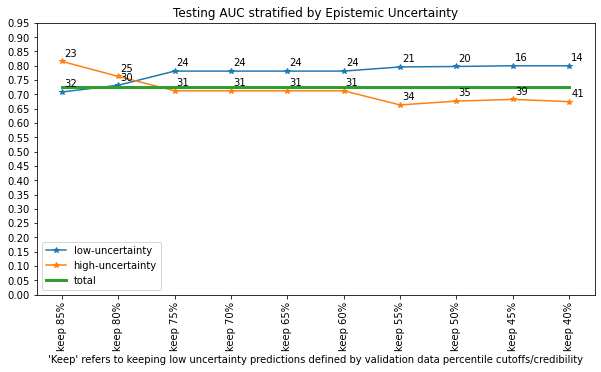

********************************************************************************
model 1


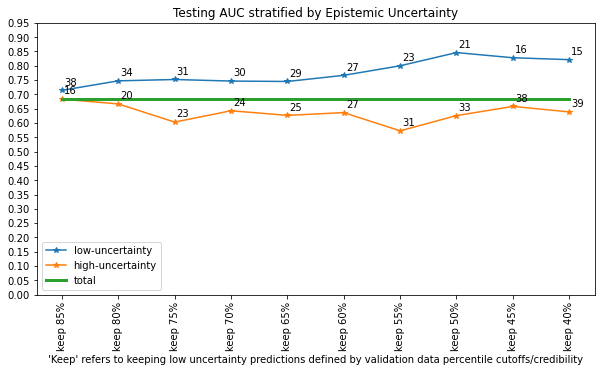

********************************************************************************
model 2


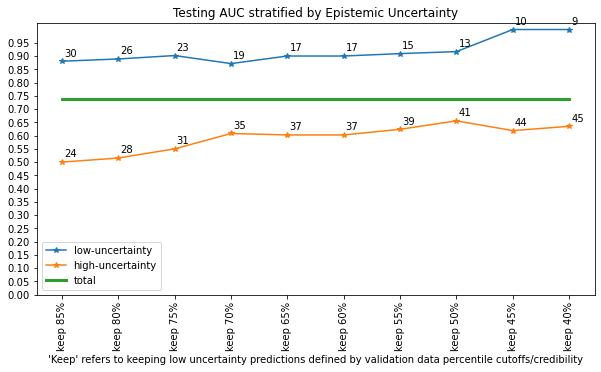

********************************************************************************
model 3


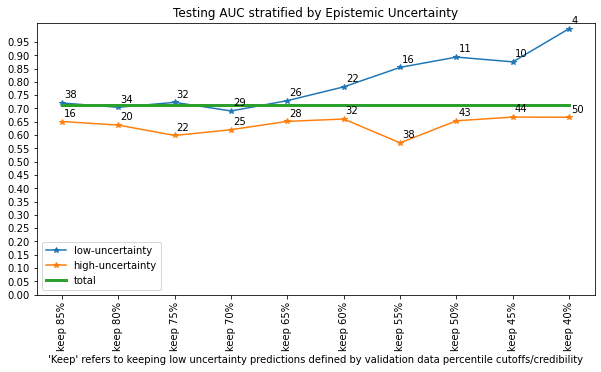

********************************************************************************
model 4


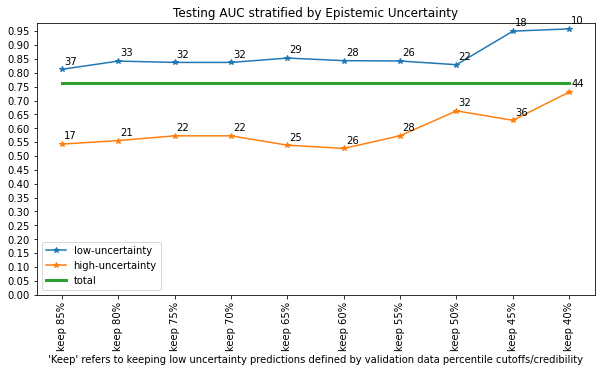

In [7]:
print('testing data')

dict_
for m in range(5):
    print('*'*80)
    print(f"model {m}")

    high_uncertainty = [dict_['all'][f"model_{m}"][x]['h_AUC'] for x in dict_['all'][f"model_{m}"] 
                        if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]
    high_uncertainty_num = [np.shape(dict_['all'][f"model_{m}"][x]['h_uncert_df'])[0] for x in dict_['all'][f"model_{m}"] 
                            if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]
    
    low_uncertainty = [dict_['all'][f"model_{m}"][x]['l_AUC'] for x in dict_['all'][f"model_{m}"] 
                       if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]
    low_uncertainty_num = [np.shape(dict_['all'][f"model_{m}"][x]['l_uncert_df'])[0] for x in dict_['all'][f"model_{m}"] 
                           if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]

    cutoff = [x.split('_')[-1] for x in dict_['all'][f"model_{m}"] 
              if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]


    plt.figure(figsize=(10,5))
    
    cutoff = cutoff[::-1]
    low_uncertainty = low_uncertainty[::-1]
    low_uncertainty_num = low_uncertainty_num[::-1]
    
    high_uncertainty = high_uncertainty[::-1]
    high_uncertainty_num = high_uncertainty_num[::-1]

    plt.plot([int(x) for x in cutoff], low_uncertainty, '-*')
    
    for i, txt in enumerate([str(x) for x in low_uncertainty_num]):
        plt.annotate(str(txt), ([int(x) for x in cutoff][i], low_uncertainty[i]), 
                     xycoords='data', textcoords='offset points', xytext=(2, 5))
    
    plt.plot([int(x) for x in cutoff], high_uncertainty, '*-')
    for i, txt in enumerate([str(x) for x in high_uncertainty_num]):
        plt.annotate(str(txt), ([int(x) for x in cutoff][i], high_uncertainty[i]), 
                     xycoords='data', textcoords='offset points', xytext=(2, 5))
    
    plt.plot([int(x) for x in cutoff], [dict_['all'][f"model_{m}"][x]['total_AUC'] for x in dict_['all'][f"model_{m}"] 
              if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range], linewidth=3)
    
    plt.legend(['low-uncertainty', 'high-uncertainty','total'], loc='lower left')
    plt.yticks(np.arange(0.0, 1, 0.05))
    plt.gca().invert_xaxis()
    plt.xticks([int(x) for x in cutoff], [f"keep {str(x)}%" for x in cutoff])
    plt.xticks(rotation = 90)
    plt.xlabel("'Keep' refers to keeping low uncertainty predictions defined by validation data percentile cutoffs/credibility")

    plt.title('Testing AUC stratified by Epistemic Uncertainty')
    
    plt.show()

validation total data


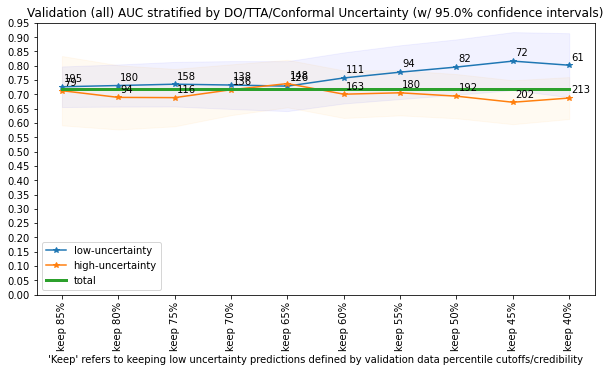

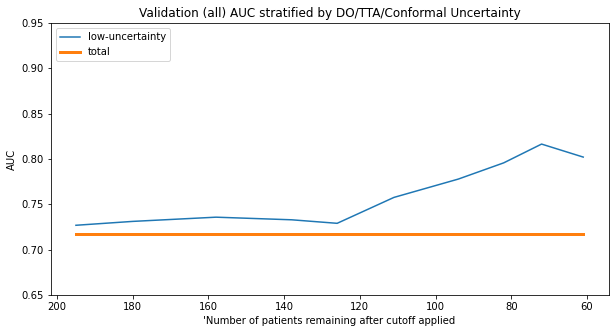

[195, 180, 158, 138, 126, 111, 94, 82, 72, 61]
[0.7267391304347826, 0.7310203559083345, 0.735672514619883, 0.7327817531305904, 0.7288995726495726, 0.7574912891986062, 0.7777217741935484, 0.7956349206349206, 0.8163636363636364, 0.8020050125313283]

Evaluating the ratio of ft/(no ft + ft)
+ then -
[19, 22, 28, 32, 41, 48, 52, 63, 73, 80]
[42, 50, 54, 62, 70, 78, 86, 95, 107, 115]
[0.31147541 0.30555556 0.34146341 0.34042553 0.36936937 0.38095238
 0.37681159 0.39873418 0.40555556 0.41025641]

+ then -
[96, 93, 87, 83, 74, 67, 63, 52, 42, 35]
[117, 109, 105, 97, 89, 81, 73, 64, 52, 44]
[0.45070423 0.46039604 0.453125   0.46111111 0.45398773 0.4527027
 0.46323529 0.44827586 0.44680851 0.44303797]


In [8]:
print('validation total data')

dict_val

total_eval_dict = {x: {} for x in cut_range}


for c in cut_range:
    high_uncertainty_df = None
    low_uncertainty_df = None
    for m in range(5):
        if m == 0:
            high_uncertainty_df = dict_val['all'][f"model_{m}"][f"c_{c}"]['h_uncert_df']
            low_uncertainty_df = dict_val['all'][f"model_{m}"][f"c_{c}"]['l_uncert_df']
        else:
            high_uncertainty_df = pd.concat([high_uncertainty_df, dict_val['all'][f"model_{m}"][f"c_{c}"]['h_uncert_df']])
            low_uncertainty_df = pd.concat([low_uncertainty_df, dict_val['all'][f"model_{m}"][f"c_{c}"]['l_uncert_df']])

        
    total_eval_dict[c]['total_df'] = pd.concat([high_uncertainty_df, low_uncertainty_df])
    total_eval_dict[c]['total_auc'] = roc_auc_score(y_true=total_eval_dict[c]['total_df']['true'], y_score=total_eval_dict[c]['total_df']['pred']) 
    total_eval_dict[c]['total_auc_95_conf'] = delong_roc_curve_analysis(y_true=total_eval_dict[c]['total_df']['true'], y_pred=total_eval_dict[c]['total_df']['pred'], alpha_ci=conf_int)[f"{conf_int*100}%_ci"]

    total_eval_dict[c]['high_uncertainty_df'] = high_uncertainty_df
    total_eval_dict[c]['high_uncertainty_num'] = np.shape(high_uncertainty_df)[0]

    try:
        total_eval_dict[c]['h_AUC'] = roc_auc_score(y_true=high_uncertainty_df['true'], y_score=high_uncertainty_df['pred']) 
        total_eval_dict[c]['h_AUC_95conf'] = delong_roc_curve_analysis(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred'], alpha_ci=conf_int)[f"{conf_int*100}%_ci"]
    except ValueError:
        total_eval_dict[c]['h_AUC'] = np.nan
        total_eval_dict[c]['h_AUC_95conf'] = np.array([np.nan, np.nan])

    total_eval_dict[c]['low_uncertainty_df'] = low_uncertainty_df
    total_eval_dict[c]['low_uncertainty_num'] = np.shape(low_uncertainty_df)[0]

    try:
        total_eval_dict[c]['l_AUC'] = roc_auc_score(y_true=low_uncertainty_df['true'], y_score=low_uncertainty_df['pred']) 
        total_eval_dict[c]['l_AUC_95conf'] = delong_roc_curve_analysis(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred'], alpha_ci=conf_int)[f"{conf_int*100}%_ci"]
    except ValueError:
        total_eval_dict[c]['l_AUC'] = np.nan
        total_eval_dict[c]['l_AUC_95conf'] = np.array([np.nan, np.nan])
        
    total_eval_dict[c]['low_num_pos'] = np.sum(low_uncertainty_df['true'])
    total_eval_dict[c]['low_num_neg'] = len(low_uncertainty_df['true']) - np.sum(low_uncertainty_df['true'])

    total_eval_dict[c]['high_num_pos'] = np.sum(high_uncertainty_df['true'])
    total_eval_dict[c]['high_num_neg'] = len(high_uncertainty_df['true']) - np.sum(high_uncertainty_df['true'])



import pprint
# pprint.pprint(total_eval_dict)

# assert 1 == 0, 'force'

cutoff = cut_range
cutoff = cutoff[::-1]

plt.figure(figsize=(10,5))

low_uncertainty = [total_eval_dict[c]['l_AUC'] for c in cutoff]
low_uncertainty_num = [total_eval_dict[c]['low_uncertainty_num'] for c in cutoff]

low_conf_interval_low = [total_eval_dict[c]['l_AUC_95conf'][0] for c in cutoff]
low_conf_interval_high = [total_eval_dict[c]['l_AUC_95conf'][1] for c in cutoff]

high_conf_interval_low = [total_eval_dict[c]['h_AUC_95conf'][0] for c in cutoff]
high_conf_interval_high = [total_eval_dict[c]['h_AUC_95conf'][1] for c in cutoff]

# low_uncertainty = low_uncertainty[::-1]
# low_uncertainty_num = low_uncertainty_num[::-1]
    

plt.plot([int(x) for x in cutoff], low_uncertainty, '-*')
plt.fill_between([int(x) for x in cutoff], (low_conf_interval_low), (low_conf_interval_high), color='blue', alpha=0.05)

for i, txt in enumerate([str(x) for x in low_uncertainty_num]):
    plt.annotate(str(txt), ([int(x) for x in cutoff][i], low_uncertainty[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))

high_uncertainty = [total_eval_dict[c]['h_AUC'] for c in cutoff]
high_uncertainty_num = [total_eval_dict[c]['high_uncertainty_num'] for c in cutoff]    

# high_uncertainty = high_uncertainty[::-1]
# high_uncertainty_num = high_uncertainty_num[::-1]

plt.plot([int(x) for x in cutoff], high_uncertainty, '*-')
plt.fill_between([int(x) for x in cutoff], (high_conf_interval_low), (high_conf_interval_high), color='orange', alpha=0.05)

for i, txt in enumerate([str(x) for x in high_uncertainty_num]):
    plt.annotate(str(txt), ([int(x) for x in cutoff][i], high_uncertainty[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))

plt.plot([int(x) for x in cutoff], [total_eval_dict[x]['total_auc'] for x in cut_range], linewidth=3)

plt.legend(['low-uncertainty', 'high-uncertainty','total'], loc='lower left')
plt.yticks(np.arange(0.0, 1, 0.05))
plt.gca().invert_xaxis()
plt.xticks([int(x) for x in cutoff], [f"keep {str(x)}%" for x in cutoff])
plt.xticks(rotation = 90)
plt.xlabel("'Keep' refers to keeping low uncertainty predictions defined by validation data percentile cutoffs/credibility")

plt.title(f"Validation (all) AUC stratified by DO/TTA/Conformal Uncertainty (w/ {conf_int*100}% confidence intervals)")

plt.show()

# AUC per patient number
plt.figure(figsize=(10,5))
plt.plot(low_uncertainty_num, low_uncertainty)
plt.plot(low_uncertainty_num, [total_eval_dict[50]['total_auc'] for x in range(len(low_uncertainty_num))], linewidth=3)
plt.legend(['low-uncertainty', 'total'], loc='upper left')
plt.yticks(np.arange(0.65, 1, 0.05))
plt.xlabel("'Number of patients remaining after cutoff applied")
plt.ylabel('AUC')
plt.title(f"Validation (all) AUC stratified by DO/TTA/Conformal Uncertainty")

plt.gca().invert_xaxis()
plt.show()

save_dir = r'C:\Users\s185479\Desktop\Python_Code\Projects\Feeding_Tube\uncertainty\uncertainty_update_20220801\save_folder'
f_name = 'val_all.csv'
print(low_uncertainty_num)
print(low_uncertainty)
df = pd.DataFrame([[low_uncertainty_num, low_uncertainty, low_conf_interval_low, low_conf_interval_high,
                    [total_eval_dict[50]['total_auc'] for x in range(len(low_uncertainty_num))]]], columns=['num', 'l_auc', 'l_auc_low_conf', 'l_auc_high_conf', 'total_auc'])
df.to_csv(os.path.join(save_dir, f_name))

f_name = 'val_all_wrong.csv'
df = pd.DataFrame([[high_uncertainty_num, high_uncertainty, high_conf_interval_low, high_conf_interval_high,
                    [total_eval_dict[50]['total_auc'] for x in range(len(low_uncertainty_num))]]], columns=['num', 'h_auc', 'h_auc_low_conf', 'h_auc_high_conf', 'total_auc'])
df.to_csv(os.path.join(save_dir, f_name))

save_ratio_dir = r'C:\Users\s185479\Desktop\Python_Code\Projects\Feeding_Tube\uncertainty\uncertainty_update_20220801\ratio'
if not os.path.exists(save_ratio_dir):
    os.mkdir(save_ratio_dir)
else:
    pass

low_ratio_name = 'val_all.npy'
high_ratio_name = 'val_all_wrong.npy'

print('')
print('Evaluating the ratio of ft/(no ft + ft)')
print('+ then -')
print([total_eval_dict[c]['low_num_pos'] for c in total_eval_dict])
print([total_eval_dict[c]['low_num_neg'] for c in total_eval_dict])
low_ratio = np.divide([total_eval_dict[c]['low_num_pos'] for c in total_eval_dict], np.add([total_eval_dict[c]['low_num_neg'] for c in total_eval_dict], [total_eval_dict[c]['low_num_pos'] for c in total_eval_dict]))
print(low_ratio)
np.save(os.path.join(save_ratio_dir, low_ratio_name), low_ratio)

print('')
print('+ then -')
print([total_eval_dict[c]['high_num_pos'] for c in total_eval_dict])
print([total_eval_dict[c]['high_num_neg'] for c in total_eval_dict])
high_ratio = np.divide([total_eval_dict[c]['high_num_pos'] for c in total_eval_dict], np.add([total_eval_dict[c]['high_num_neg'] for c in total_eval_dict], [total_eval_dict[c]['high_num_pos'] for c in total_eval_dict]))
print(high_ratio)
np.save(os.path.join(save_ratio_dir, high_ratio_name), high_ratio)

testing total data


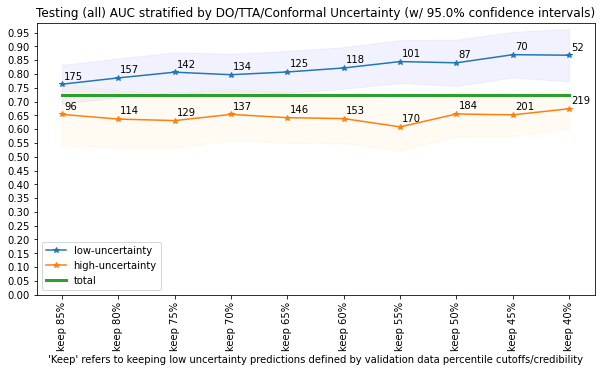

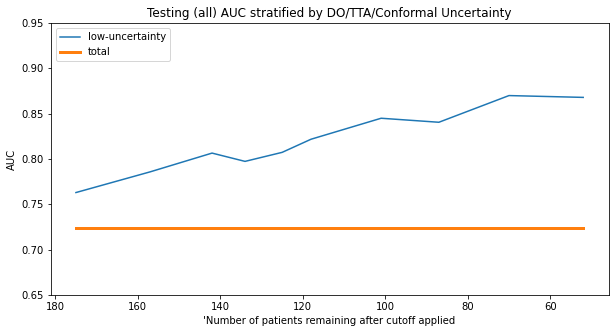


Evaluating the ratio of ft/(no ft + ft)
+ then -
[21, 28, 31, 36, 43, 45, 47, 52, 59, 71]
[31, 42, 56, 65, 75, 80, 87, 90, 98, 104]
[0.40384615 0.4        0.35632184 0.35643564 0.36440678 0.36
 0.35074627 0.36619718 0.37579618 0.40571429]

+ then -
[94, 87, 84, 79, 72, 70, 68, 63, 56, 44]
[125, 114, 100, 91, 81, 76, 69, 66, 58, 52]
[0.42922374 0.43283582 0.45652174 0.46470588 0.47058824 0.47945205
 0.49635036 0.48837209 0.49122807 0.45833333]


In [9]:
print('testing total data')

dict_

total_eval_dict = {x: {} for x in cut_range}

for c in cut_range:
    high_uncertainty_df = None
    low_uncertainty_df = None
    for m in range(5):
        if m == 0:
            high_uncertainty_df = dict_['all'][f"model_{m}"][f"c_{c}"]['h_uncert_df']
            low_uncertainty_df = dict_['all'][f"model_{m}"][f"c_{c}"]['l_uncert_df']
        else:
            high_uncertainty_df = pd.concat([high_uncertainty_df, dict_['all'][f"model_{m}"][f"c_{c}"]['h_uncert_df']])
            low_uncertainty_df = pd.concat([low_uncertainty_df, dict_['all'][f"model_{m}"][f"c_{c}"]['l_uncert_df']])

        
    total_eval_dict[c]['total_df'] = pd.concat([high_uncertainty_df, low_uncertainty_df])
    total_eval_dict[c]['total_auc'] = roc_auc_score(y_true=total_eval_dict[c]['total_df']['true'], y_score=total_eval_dict[c]['total_df']['pred']) 
    total_eval_dict[c]['total_auc_95_conf'] = delong_roc_curve_analysis(y_true=total_eval_dict[c]['total_df']['true'], y_pred=total_eval_dict[c]['total_df']['pred'], alpha_ci=conf_int)[f"{conf_int*100}%_ci"]

    total_eval_dict[c]['high_uncertainty_df'] = high_uncertainty_df
    total_eval_dict[c]['high_uncertainty_num'] = np.shape(high_uncertainty_df)[0]

    try:
        total_eval_dict[c]['h_AUC'] = roc_auc_score(y_true=high_uncertainty_df['true'], y_score=high_uncertainty_df['pred']) 
        total_eval_dict[c]['h_AUC_95conf'] = delong_roc_curve_analysis(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred'], alpha_ci=conf_int)[f"{conf_int*100}%_ci"]
    except ValueError:
        total_eval_dict[c]['h_AUC'] = np.nan
        total_eval_dict[c]['h_AUC_95conf'] = np.array([np.nan, np.nan])

    total_eval_dict[c]['low_uncertainty_df'] = low_uncertainty_df
    total_eval_dict[c]['low_uncertainty_num'] = np.shape(low_uncertainty_df)[0]

    try:
        total_eval_dict[c]['l_AUC'] = roc_auc_score(y_true=low_uncertainty_df['true'], y_score=low_uncertainty_df['pred']) 
        total_eval_dict[c]['l_AUC_95conf'] = delong_roc_curve_analysis(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred'], alpha_ci=conf_int)[f"{conf_int*100}%_ci"]
    except ValueError:
        total_eval_dict[c]['l_AUC'] = np.nan
        total_eval_dict[c]['l_AUC_95conf'] = np.array([np.nan, np.nan])
        
    total_eval_dict[c]['low_num_pos'] = np.sum(low_uncertainty_df['true'])
    total_eval_dict[c]['low_num_neg'] = len(low_uncertainty_df['true']) - np.sum(low_uncertainty_df['true'])

    total_eval_dict[c]['high_num_pos'] = np.sum(high_uncertainty_df['true'])
    total_eval_dict[c]['high_num_neg'] = len(high_uncertainty_df['true']) - np.sum(high_uncertainty_df['true'])


cutoff = cut_range[::-1]

plt.figure(figsize=(10,5))

low_uncertainty = [total_eval_dict[c]['l_AUC'] for c in cutoff]
low_uncertainty_num = [total_eval_dict[c]['low_uncertainty_num'] for c in cutoff]

low_uncertainty = [total_eval_dict[c]['l_AUC'] for c in cutoff]
low_uncertainty_num = [total_eval_dict[c]['low_uncertainty_num'] for c in cutoff]

low_conf_interval_low = [total_eval_dict[c]['l_AUC_95conf'][0] for c in cutoff]
low_conf_interval_high = [total_eval_dict[c]['l_AUC_95conf'][1] for c in cutoff]

high_conf_interval_low = [total_eval_dict[c]['h_AUC_95conf'][0] for c in cutoff]
high_conf_interval_high = [total_eval_dict[c]['h_AUC_95conf'][1] for c in cutoff]

plt.plot([int(x) for x in cutoff], low_uncertainty, '-*')
plt.fill_between([int(x) for x in cutoff], (low_conf_interval_low), (low_conf_interval_high), color='blue', alpha=0.05)

for i, txt in enumerate([str(x) for x in low_uncertainty_num]):
    plt.annotate(str(txt), ([int(x) for x in cutoff][i], low_uncertainty[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))

high_uncertainty = [total_eval_dict[c]['h_AUC'] for c in cutoff]
high_uncertainty_num = [total_eval_dict[c]['high_uncertainty_num'] for c in cutoff]    

plt.plot([int(x) for x in cutoff], high_uncertainty, '*-')
plt.fill_between([int(x) for x in cutoff], (high_conf_interval_low), (high_conf_interval_high), color='orange', alpha=0.05)

for i, txt in enumerate([str(x) for x in high_uncertainty_num]):
    plt.annotate(str(txt), ([int(x) for x in cutoff][i], high_uncertainty[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))

plt.plot([int(x) for x in cutoff], [total_eval_dict[x]['total_auc'] for x in cut_range], linewidth=3)

plt.legend(['low-uncertainty', 'high-uncertainty','total'], loc='lower left')
plt.yticks(np.arange(0.0, 1, 0.05))
plt.gca().invert_xaxis()
plt.xticks([int(x) for x in cutoff], [f"keep {str(x)}%" for x in cutoff])
plt.xticks(rotation = 90)
plt.xlabel("'Keep' refers to keeping low uncertainty predictions defined by validation data percentile cutoffs/credibility")

plt.title(f"Testing (all) AUC stratified by DO/TTA/Conformal Uncertainty (w/ {conf_int*100}% confidence intervals)")

plt.show()

# AUC per patient number
plt.figure(figsize=(10,5))
plt.plot(low_uncertainty_num, low_uncertainty)
plt.plot(low_uncertainty_num, [total_eval_dict[50]['total_auc'] for x in range(len(low_uncertainty_num))], linewidth=3)
plt.legend(['low-uncertainty', 'total'], loc='upper left')
plt.yticks(np.arange(0.65, 1, 0.05))
plt.xlabel("'Number of patients remaining after cutoff applied")
plt.ylabel('AUC')
plt.title(f"Testing (all) AUC stratified by DO/TTA/Conformal Uncertainty")

plt.gca().invert_xaxis()
plt.show()

save_dir = r'C:\Users\s185479\Desktop\Python_Code\Projects\Feeding_Tube\uncertainty\uncertainty_update_20220801\save_folder'
f_name = 'test_all.csv'
df = pd.DataFrame([[low_uncertainty_num, low_uncertainty, low_conf_interval_low, low_conf_interval_high,
                    [total_eval_dict[50]['total_auc'] for x in range(len(low_uncertainty_num))]]], columns=['num', 'l_auc', 'l_auc_low_conf', 'l_auc_high_conf', 'total_auc'])
df.to_csv(os.path.join(save_dir, f_name))

f_name = 'test_all_wrong.csv'
df = pd.DataFrame([[high_uncertainty_num, high_uncertainty, high_conf_interval_low, high_conf_interval_high,
                    [total_eval_dict[50]['total_auc'] for x in range(len(low_uncertainty_num))]]], columns=['num', 'h_auc', 'h_auc_low_conf', 'h_auc_high_conf', 'total_auc'])
df.to_csv(os.path.join(save_dir, f_name))

save_ratio_dir = r'C:\Users\s185479\Desktop\Python_Code\Projects\Feeding_Tube\uncertainty\uncertainty_update_20220801\ratio'
if not os.path.exists(save_ratio_dir):
    os.mkdir(save_ratio_dir)
else:
    pass

low_ratio_name = 'test_all.npy'
high_ratio_name = 'test_all_wrong.npy'

print('')
print('Evaluating the ratio of ft/(no ft + ft)')
print('+ then -')
print([total_eval_dict[c]['low_num_pos'] for c in total_eval_dict])
print([total_eval_dict[c]['low_num_neg'] for c in total_eval_dict])
low_ratio = np.divide([total_eval_dict[c]['low_num_pos'] for c in total_eval_dict], np.add([total_eval_dict[c]['low_num_neg'] for c in total_eval_dict], [total_eval_dict[c]['low_num_pos'] for c in total_eval_dict]))
print(low_ratio)
np.save(os.path.join(save_ratio_dir, low_ratio_name), low_ratio)

print('')
print('+ then -')
print([total_eval_dict[c]['high_num_pos'] for c in total_eval_dict])
print([total_eval_dict[c]['high_num_neg'] for c in total_eval_dict])
high_ratio = np.divide([total_eval_dict[c]['high_num_pos'] for c in total_eval_dict], np.add([total_eval_dict[c]['high_num_neg'] for c in total_eval_dict], [total_eval_dict[c]['high_num_pos'] for c in total_eval_dict]))
print(high_ratio)
np.save(os.path.join(save_ratio_dir, high_ratio_name), high_ratio)

testing data acc
********************************************************************************
model 0


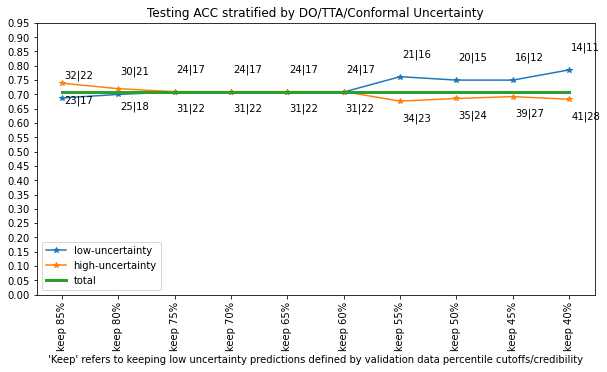

********************************************************************************
model 1


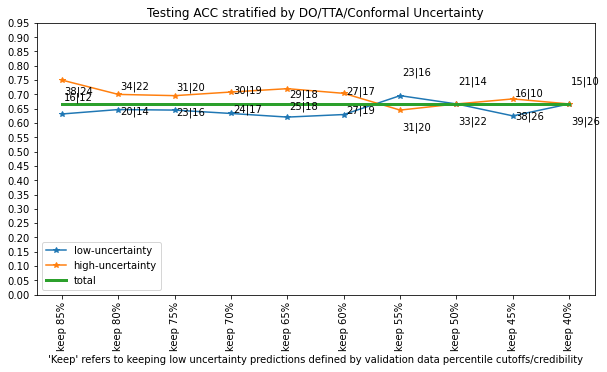

********************************************************************************
model 2


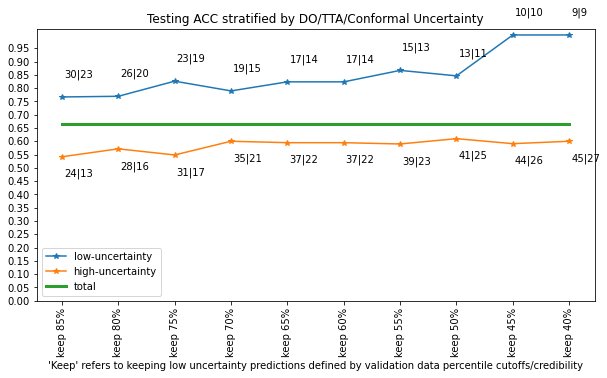

********************************************************************************
model 3


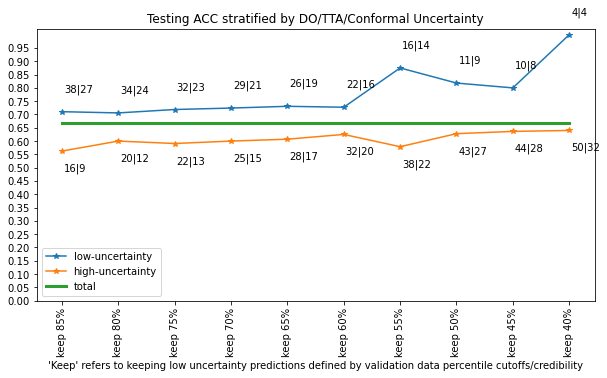

********************************************************************************
model 4


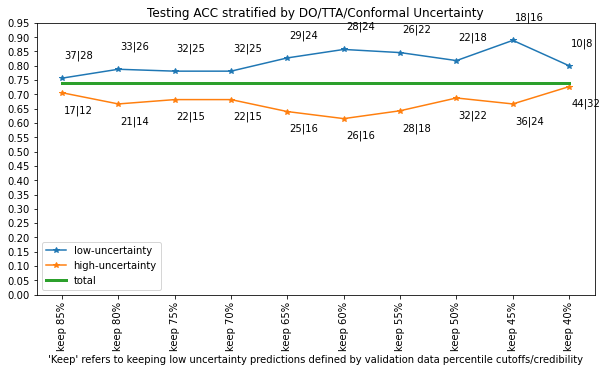

In [10]:
print('testing data acc')

dict_
for m in range(5):
    print('*'*80)
    print(f"model {m}")


    high_uncertainty_num = [np.shape(dict_['all'][f"model_{m}"][x]['h_uncert_df'])[0] for x in dict_['all'][f"model_{m}"] 
                            if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]
    
    high_acc = [dict_['all'][f"model_{m}"][x]['h_acc'] for x in dict_['all'][f"model_{m}"] 
                        if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]

    h_correct = [dict_['all'][f"model_{m}"][x]['h_correct'] for x in dict_['all'][f"model_{m}"] 
                       if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]

    low_uncertainty_num = [np.shape(dict_['all'][f"model_{m}"][x]['l_uncert_df'])[0] for x in dict_['all'][f"model_{m}"] 
                           if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]
    
    low_acc = [dict_['all'][f"model_{m}"][x]['l_acc'] for x in dict_['all'][f"model_{m}"] 
                       if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]
    
    l_correct = [dict_['all'][f"model_{m}"][x]['l_correct'] for x in dict_['all'][f"model_{m}"] 
                       if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]


    cutoff = [x.split('_')[-1] for x in dict_['all'][f"model_{m}"] 
              if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]
    
    cutoff = cutoff[::-1]
    low_acc = low_acc[::-1]
    low_uncertainty_num = low_uncertainty_num[::-1]
    l_correct = l_correct[::-1]
    
    high_acc = high_acc[::-1]
    high_uncertainty_num = high_uncertainty_num[::-1]
    h_correct = h_correct[::-1]


    plt.figure(figsize=(10,5))
    

    plt.plot([int(x) for x in cutoff], low_acc, '-*')
    
    for i, txt in enumerate(list(zip([str(x) for x in low_uncertainty_num], l_correct))):
        plt.annotate(str(txt[0])+'|'+str(txt[1]), ([int(x) for x in cutoff][i], low_acc[i]), 
                     xycoords='data', textcoords='offset points', xytext=(2, 20))
    
    plt.plot([int(x) for x in cutoff], high_acc, '*-')
    for i, txt in enumerate(list(zip([str(x) for x in high_uncertainty_num], h_correct))):
        plt.annotate(str(txt[0])+'|'+str(txt[1]), ([int(x) for x in cutoff][i], high_acc[i]), 
                     xycoords='data', textcoords='offset points', xytext=(2, -20))
    
    
    plt.plot([int(x) for x in cutoff], [dict_['all'][f"model_{m}"][x]['total_acc'] for x in dict_['all'][f"model_{m}"] 
              if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range], linewidth=3)
    
    plt.legend(['low-uncertainty', 'high-uncertainty','total'], loc='lower left')
    plt.yticks(np.arange(0.0, 1, 0.05))
    plt.gca().invert_xaxis()
    plt.xticks([int(x) for x in cutoff], [f"keep {str(x)}%" for x in cutoff])
    plt.xticks(rotation = 90)
    plt.xlabel("'Keep' refers to keeping low uncertainty predictions defined by validation data percentile cutoffs/credibility")

    plt.title('Testing ACC stratified by DO/TTA/Conformal Uncertainty')
    
    plt.show()

val total data


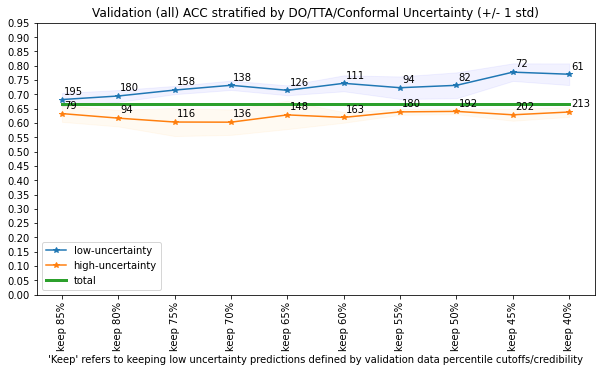

In [11]:
print('val total data')

dict_val

total_eval_dict = {x: {} for x in cut_range}


for c in cut_range:
    high_uncertainty_df = None
    low_uncertainty_df = None
    cut_low_acc = []
    cut_high_acc = []
    for m in range(5):
        if m == 0:
            high_uncertainty_df = dict_val['all'][f"model_{m}"][f"c_{c}"]['h_uncert_df']
            low_uncertainty_df = dict_val['all'][f"model_{m}"][f"c_{c}"]['l_uncert_df']
            
            cut_low_acc.append(acc(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final']))
            cut_high_acc.append(acc(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final']))
            
        else:
            high_uncertainty_df = pd.concat([high_uncertainty_df, dict_val['all'][f"model_{m}"][f"c_{c}"]['h_uncert_df']])
            low_uncertainty_df = pd.concat([low_uncertainty_df, dict_val['all'][f"model_{m}"][f"c_{c}"]['l_uncert_df']])
            
            cut_low_acc.append(acc(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final']))
            cut_high_acc.append(acc(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final']))

        
    total_eval_dict[c]['total_df'] = pd.concat([high_uncertainty_df, low_uncertainty_df])
    total_eval_dict[c]['total_acc'] = acc(y_true=total_eval_dict[c]['total_df']['true'], y_pred=total_eval_dict[c]['total_df']['pred_final'])  
    total_eval_dict[c]['fold_l_acc'] = cut_low_acc
    total_eval_dict[c]['fold_h_acc'] = cut_high_acc
    total_eval_dict[c]['high_uncertainty_df'] = high_uncertainty_df
    total_eval_dict[c]['high_uncertainty_num'] = np.shape(high_uncertainty_df)[0]

    try:
        total_eval_dict[c]['h_acc'] = acc(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final']) 
        total_eval_dict[c]['h_acc_std'] = np.std(total_eval_dict[c]['fold_h_acc'])
    except ValueError:
        total_eval_dict[c]['h_acc'] = np.nan
        total_eval_dict[c]['h_acc_std'] = np.nan

    total_eval_dict[c]['low_uncertainty_df'] = low_uncertainty_df
    total_eval_dict[c]['low_uncertainty_num'] = np.shape(low_uncertainty_df)[0]

    try:
        total_eval_dict[c]['l_acc'] = acc(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final']) 
        total_eval_dict[c]['l_acc_std'] = np.std(total_eval_dict[c]['fold_l_acc'])
    except ValueError:
        total_eval_dict[c]['l_acc'] = np.nan
        total_eval_dict[c]['l_acc_std'] = np.nan
        

import pprint

cutoff = cut_range
cutoff = cutoff[::-1]

plt.figure(figsize=(10,5))

low_uncertainty = [total_eval_dict[c]['l_acc'] for c in cutoff]
low_uncertainty_num = [total_eval_dict[c]['low_uncertainty_num'] for c in cutoff]
low_std_low = [total_eval_dict[c]['l_acc'] - std_num*total_eval_dict[c]['l_acc_std'] for c in cutoff]
low_std_high = [total_eval_dict[c]['l_acc'] + std_num*total_eval_dict[c]['l_acc_std'] for c in cutoff]


plt.plot([int(x) for x in cutoff], low_uncertainty, '-*')
plt.fill_between([int(x) for x in cutoff], (low_std_low), (low_std_high), color='blue', alpha=0.05)

for i, txt in enumerate([str(x) for x in low_uncertainty_num]):
    plt.annotate(str(txt), ([int(x) for x in cutoff][i], low_uncertainty[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))

high_uncertainty = [total_eval_dict[c]['h_acc'] for c in cutoff]
high_uncertainty_num = [total_eval_dict[c]['high_uncertainty_num'] for c in cutoff]    
high_std_low = [total_eval_dict[c]['h_acc'] - std_num*total_eval_dict[c]['h_acc_std'] for c in cutoff]
high_std_high = [total_eval_dict[c]['h_acc'] + std_num*total_eval_dict[c]['h_acc_std'] for c in cutoff]

plt.plot([int(x) for x in cutoff], high_uncertainty, '*-')
plt.fill_between([int(x) for x in cutoff], (high_std_low), (high_std_high), color='orange', alpha=0.05)

for i, txt in enumerate([str(x) for x in high_uncertainty_num]):
    plt.annotate(str(txt), ([int(x) for x in cutoff][i], high_uncertainty[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))

plt.plot([int(x) for x in cutoff], [total_eval_dict[x]['total_acc'] for x in cut_range], linewidth=3)

plt.legend(['low-uncertainty', 'high-uncertainty','total'], loc='lower left')
plt.yticks(np.arange(0.0, 1, 0.05))
plt.gca().invert_xaxis()
plt.xticks([int(x) for x in cutoff], [f"keep {str(x)}%" for x in cutoff])
plt.xticks(rotation = 90)
plt.xlabel("'Keep' refers to keeping low uncertainty predictions defined by validation data percentile cutoffs/credibility")

plt.title(f"Validation (all) ACC stratified by DO/TTA/Conformal Uncertainty (+/- {std_num} std)")

plt.show()

testing total data


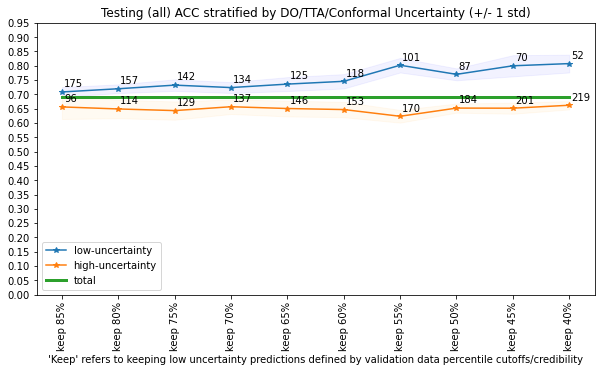

In [12]:
print('testing total data')

dict_

total_eval_dict = {x: {} for x in cut_range}


for c in cut_range:
    high_uncertainty_df = None
    low_uncertainty_df = None
    cut_low_acc = []
    cut_high_acc = []
    for m in range(5):
        if m == 0:
            high_uncertainty_df = dict_['all'][f"model_{m}"][f"c_{c}"]['h_uncert_df']
            low_uncertainty_df = dict_['all'][f"model_{m}"][f"c_{c}"]['l_uncert_df']
            
            cut_low_acc.append(acc(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final']))
            cut_high_acc.append(acc(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final']))
            
        else:
            high_uncertainty_df = pd.concat([high_uncertainty_df, dict_['all'][f"model_{m}"][f"c_{c}"]['h_uncert_df']])
            low_uncertainty_df = pd.concat([low_uncertainty_df, dict_['all'][f"model_{m}"][f"c_{c}"]['l_uncert_df']])
            
            cut_low_acc.append(acc(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final']))
            cut_high_acc.append(acc(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final']))

        
    total_eval_dict[c]['total_df'] = pd.concat([high_uncertainty_df, low_uncertainty_df])
    total_eval_dict[c]['total_acc'] = acc(y_true=total_eval_dict[c]['total_df']['true'], y_pred=total_eval_dict[c]['total_df']['pred_final'])  
    total_eval_dict[c]['fold_l_acc'] = cut_low_acc
    total_eval_dict[c]['fold_h_acc'] = cut_high_acc
    total_eval_dict[c]['high_uncertainty_df'] = high_uncertainty_df
    total_eval_dict[c]['high_uncertainty_num'] = np.shape(high_uncertainty_df)[0]

    try:
        total_eval_dict[c]['h_acc'] = acc(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final']) 
        total_eval_dict[c]['h_acc_std'] = np.std(total_eval_dict[c]['fold_h_acc'])
    except ValueError:
        total_eval_dict[c]['h_acc'] = np.nan
        total_eval_dict[c]['h_acc_std'] = np.nan

    total_eval_dict[c]['low_uncertainty_df'] = low_uncertainty_df
    total_eval_dict[c]['low_uncertainty_num'] = np.shape(low_uncertainty_df)[0]

    try:
        total_eval_dict[c]['l_acc'] = acc(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final']) 
        total_eval_dict[c]['l_acc_std'] = np.std(total_eval_dict[c]['fold_l_acc'])
    except ValueError:
        total_eval_dict[c]['l_acc'] = np.nan
        total_eval_dict[c]['l_acc_std'] = np.nan
        

import pprint

cutoff = cut_range
cutoff = cutoff[::-1]

plt.figure(figsize=(10,5))

low_uncertainty = [total_eval_dict[c]['l_acc'] for c in cutoff]
low_uncertainty_num = [total_eval_dict[c]['low_uncertainty_num'] for c in cutoff]
low_std_low = [total_eval_dict[c]['l_acc'] - std_num*total_eval_dict[c]['l_acc_std'] for c in cutoff]
low_std_high = [total_eval_dict[c]['l_acc'] + std_num*total_eval_dict[c]['l_acc_std'] for c in cutoff]


plt.plot([int(x) for x in cutoff], low_uncertainty, '-*')
plt.fill_between([int(x) for x in cutoff], (low_std_low), (low_std_high), color='blue', alpha=0.05)

for i, txt in enumerate([str(x) for x in low_uncertainty_num]):
    plt.annotate(str(txt), ([int(x) for x in cutoff][i], low_uncertainty[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))

high_uncertainty = [total_eval_dict[c]['h_acc'] for c in cutoff]
high_uncertainty_num = [total_eval_dict[c]['high_uncertainty_num'] for c in cutoff]    
high_std_low = [total_eval_dict[c]['h_acc'] - std_num*total_eval_dict[c]['h_acc_std'] for c in cutoff]
high_std_high = [total_eval_dict[c]['h_acc'] + std_num*total_eval_dict[c]['h_acc_std'] for c in cutoff]

plt.plot([int(x) for x in cutoff], high_uncertainty, '*-')
plt.fill_between([int(x) for x in cutoff], (high_std_low), (high_std_high), color='orange', alpha=0.05)

for i, txt in enumerate([str(x) for x in high_uncertainty_num]):
    plt.annotate(str(txt), ([int(x) for x in cutoff][i], high_uncertainty[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))

plt.plot([int(x) for x in cutoff], [total_eval_dict[x]['total_acc'] for x in cut_range], linewidth=3)

plt.legend(['low-uncertainty', 'high-uncertainty','total'], loc='lower left')
plt.yticks(np.arange(0.0, 1, 0.05))
plt.gca().invert_xaxis()
plt.xticks([int(x) for x in cutoff], [f"keep {str(x)}%" for x in cutoff])
plt.xticks(rotation = 90)
plt.xlabel("'Keep' refers to keeping low uncertainty predictions defined by validation data percentile cutoffs/credibility")

plt.title(f"Testing (all) ACC stratified by DO/TTA/Conformal Uncertainty (+/- {std_num} std)")

plt.show()

testing sens/spec
********************************************************************************
model 0


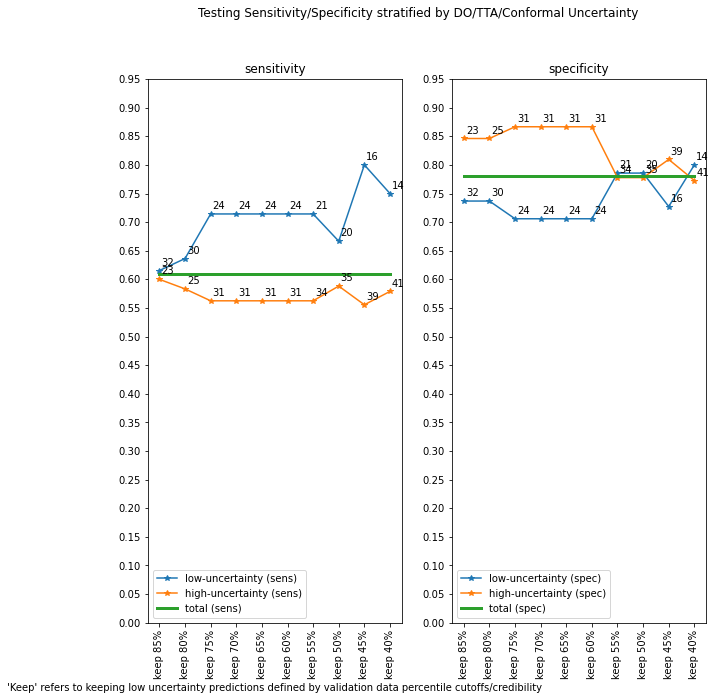

********************************************************************************
model 1


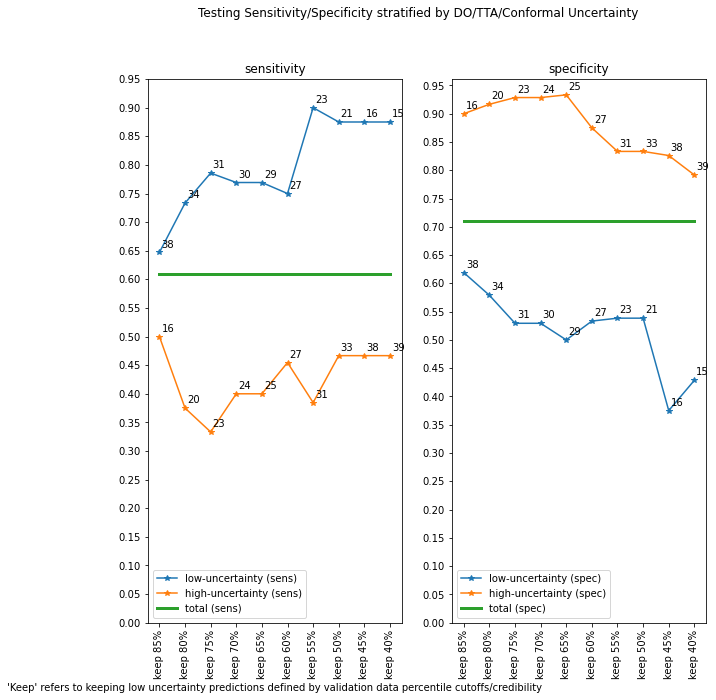

********************************************************************************
model 2


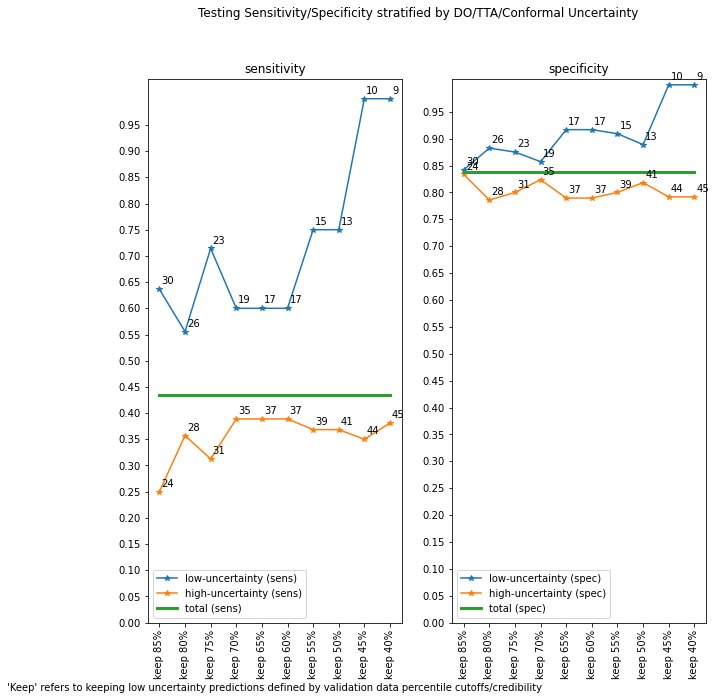

********************************************************************************
model 3


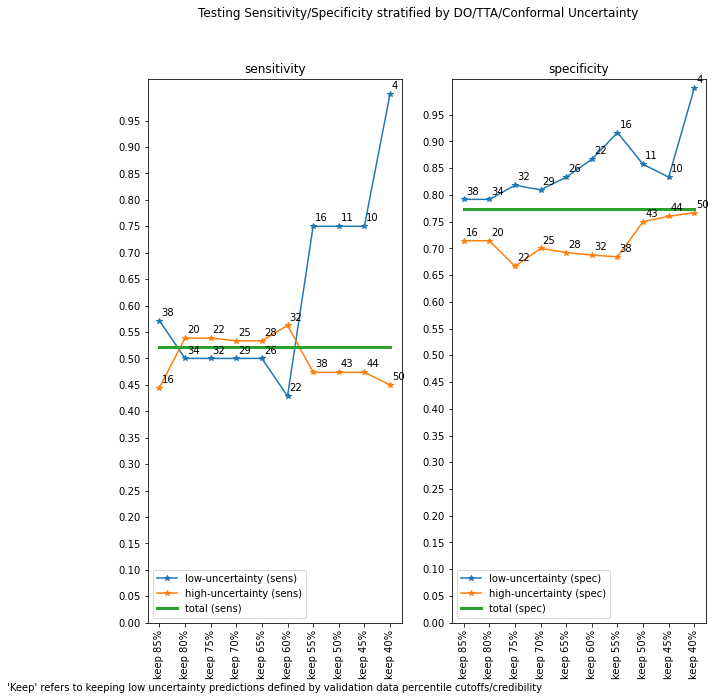

********************************************************************************
model 4


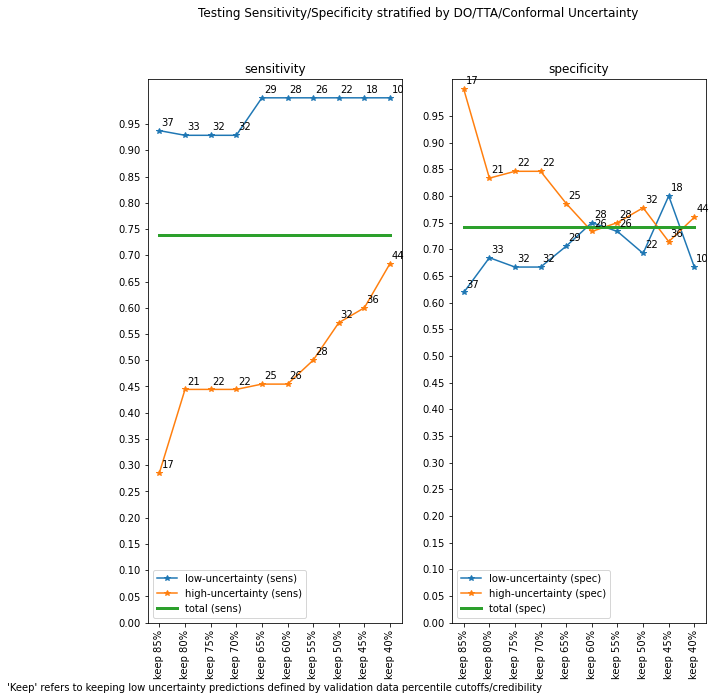

In [13]:
print('testing sens/spec')

dict_
for m in range(5):
    print('*'*80)
    print(f"model {m}")

    high_sens = [dict_['all'][f"model_{m}"][x]['h_sens'] for x in dict_['all'][f"model_{m}"] 
                        if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]
    high_uncertainty_num = [np.shape(dict_['all'][f"model_{m}"][x]['h_uncert_df'])[0] for x in dict_['all'][f"model_{m}"] 
                            if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]
    
    high_spec = [dict_['all'][f"model_{m}"][x]['h_spec'] for x in dict_['all'][f"model_{m}"] 
                        if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]


    low_sens = [dict_['all'][f"model_{m}"][x]['l_sens'] for x in dict_['all'][f"model_{m}"] 
                       if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]
    low_uncertainty_num = [np.shape(dict_['all'][f"model_{m}"][x]['l_uncert_df'])[0] for x in dict_['all'][f"model_{m}"] 
                           if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]
    
    low_spec = [dict_['all'][f"model_{m}"][x]['l_spec'] for x in dict_['all'][f"model_{m}"] 
                       if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]


    cutoff = [x.split('_')[-1] for x in dict_['all'][f"model_{m}"] 
              if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range]
    
    cutoff = cutoff[::-1]
    high_sens = high_sens[::-1]
    high_uncertainty_num = high_uncertainty_num[::-1]
    high_spec = high_spec[::-1]
    
    low_sens = low_sens[::-1]
    low_uncertainty_num = low_uncertainty_num[::-1]
    low_spec = low_spec[::-1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))

    ax1.plot([int(x) for x in cutoff], low_sens, '-*')
    
    for i, txt in enumerate([str(x) for x in low_uncertainty_num]):
        ax1.annotate(str(txt), ([int(x) for x in cutoff][i], low_sens[i]), 
                     xycoords='data', textcoords='offset points', xytext=(2, 5))
    
    ax1.plot([int(x) for x in cutoff], high_sens, '*-')
    for i, txt in enumerate([str(x) for x in high_uncertainty_num]):
        ax1.annotate(str(txt), ([int(x) for x in cutoff][i], high_sens[i]), 
                     xycoords='data', textcoords='offset points', xytext=(2, 5))
    
    
    ax1.plot([int(x) for x in cutoff], [dict_['all'][f"model_{m}"][x]['total_sens'] for x in dict_['all'][f"model_{m}"] 
              if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range], linewidth=3)
    
    ax1.legend(['low-uncertainty (sens)', 'high-uncertainty (sens)','total (sens)'], loc='lower left')
    
    ax1.set_title('sensitivity')
    ax1.set_yticks(np.arange(0.0, 1, 0.05))
    
    ax1.invert_xaxis()
    ax1.set_xticks([int(x) for x in cutoff])
    ax1.set_xticklabels([f"keep {str(x)}%" for x in cutoff], rotation = 90)
    ax1.set_xlabel("'Keep' refers to keeping low uncertainty predictions defined by validation data percentile cutoffs/credibility")

    
    # specificity
    
    ax2.plot([int(x) for x in cutoff], low_spec, '-*')
    
    for i, txt in enumerate([str(x) for x in low_uncertainty_num]):
        ax2.annotate(str(txt), ([int(x) for x in cutoff][i], low_spec[i]), 
                     xycoords='data', textcoords='offset points', xytext=(2, 5))
    
    ax2.plot([int(x) for x in cutoff], high_spec, '*-')
    for i, txt in enumerate([str(x) for x in high_uncertainty_num]):
        ax2.annotate(str(txt), ([int(x) for x in cutoff][i], high_spec[i]), 
                     xycoords='data', textcoords='offset points', xytext=(2, 5))
    
    
    ax2.plot([int(x) for x in cutoff], [dict_['all'][f"model_{m}"][x]['total_spec'] for x in dict_['all'][f"model_{m}"] 
              if float(x.split('_')[-1])>=min_cut and float(x.split('_')[-1]) in cut_range], linewidth=3)
    
    ax2.legend(['low-uncertainty (spec)', 'high-uncertainty (spec)','total (spec)'], loc='lower left')
    
    ax2.set_yticks(np.arange(0.0, 1, 0.05))
    ax2.invert_xaxis()
    ax2.set_xticks([int(x) for x in cutoff])
    ax2.set_xticklabels([f"keep {str(x)}%" for x in cutoff], rotation = 90)
    
#     ax2.set_xlabel("'Keep' refers to keeping low uncertainty predictions defined by validation data percentile cutoffs")

    ax2.set_title('specificity')

    fig.suptitle('Testing Sensitivity/Specificity stratified by DO/TTA/Conformal Uncertainty')
    
    plt.show()

val total data
True
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
confid
confid
confid
confid


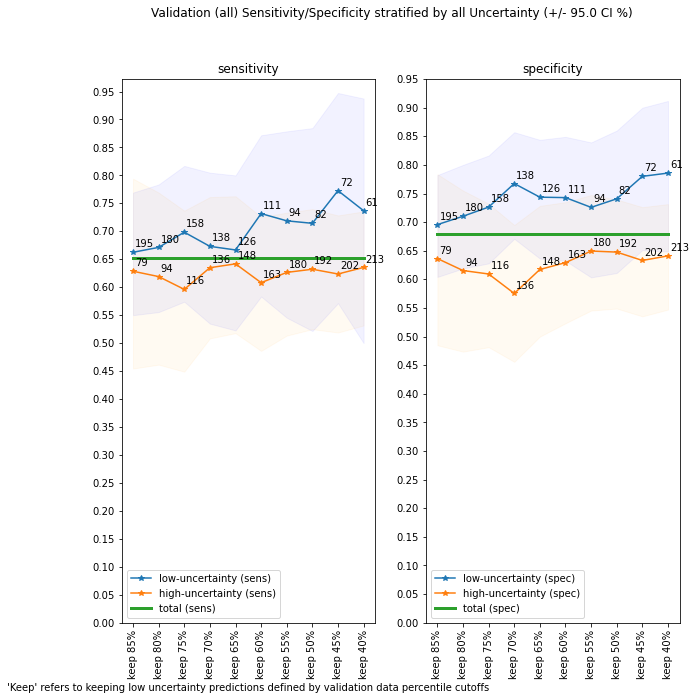

In [14]:
print('val total data')
print(bootstrap_)

dict_val

total_eval_dict = {x: {} for x in cut_range}


for c in cut_range:
    high_uncertainty_df = None
    low_uncertainty_df = None
    
    low_sens_cut = []
    low_spec_cut = []
    
    high_sens_cut = []
    high_spec_cut = []
    
    for m in range(5):
        if m == 0:
            high_uncertainty_df = dict_val['all'][f"model_{m}"][f"c_{c}"]['h_uncert_df']
            low_uncertainty_df = dict_val['all'][f"model_{m}"][f"c_{c}"]['l_uncert_df']
            
            specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final'])
            low_sens_cut.append(sensitivity)
            low_spec_cut.append(specificity)
            
            specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final'])
            high_sens_cut.append(sensitivity)
            high_spec_cut.append(specificity)
            
        else:
            high_uncertainty_df = pd.concat([high_uncertainty_df, dict_val['all'][f"model_{m}"][f"c_{c}"]['h_uncert_df']])
            low_uncertainty_df = pd.concat([low_uncertainty_df, dict_val['all'][f"model_{m}"][f"c_{c}"]['l_uncert_df']])
            
            specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final'])
            low_sens_cut.append(sensitivity)
            low_spec_cut.append(specificity)
            
            specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final'])
            high_sens_cut.append(sensitivity)
            high_spec_cut.append(specificity)

        
    total_eval_dict[c]['total_df'] = pd.concat([high_uncertainty_df, low_uncertainty_df])   
    total_eval_dict[c]['high_uncertainty_df'] = high_uncertainty_df
    total_eval_dict[c]['high_uncertainty_num'] = np.shape(high_uncertainty_df)[0]

    total_eval_dict[c]['low_uncertainty_df'] = low_uncertainty_df
    total_eval_dict[c]['low_uncertainty_num'] = np.shape(low_uncertainty_df)[0]
    
    
    total_eval_dict[c]['fold_l_sens'] = low_sens_cut
    total_eval_dict[c]['fold_h_sens'] = high_sens_cut
    total_eval_dict[c]['fold_l_spec'] = low_spec_cut
    total_eval_dict[c]['fold_h_spec'] = high_spec_cut
    

    total_eval_dict[c]['l_sens_std'] = np.std(total_eval_dict[c]['fold_l_sens'])
    total_eval_dict[c]['h_sens_std'] = np.std(total_eval_dict[c]['fold_h_sens'])
    total_eval_dict[c]['l_spec_std'] = np.std(total_eval_dict[c]['fold_l_spec'])
    total_eval_dict[c]['h_spec_std'] = np.std(total_eval_dict[c]['fold_h_spec'])
    
    
    # confidence interval
    if bootstrap_:
        low_stats_dict = bootstrap_outcome(low_uncertainty_df, n_iter=9999, size=0.90, conf_int=conf_int)
        total_eval_dict[c]['l_sens_conf'] = low_stats_dict['sensitivity']
        total_eval_dict[c]['l_spec_conf'] = low_stats_dict['specificity']

        high_stats_dict = bootstrap_outcome(high_uncertainty_df, n_iter=9999, size=0.90, conf_int=conf_int)
        total_eval_dict[c]['h_sens_conf'] = high_stats_dict['sensitivity']
        total_eval_dict[c]['h_spec_conf'] = high_stats_dict['specificity']
    ###


    specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=total_eval_dict[c]['total_df']['true'], y_pred=total_eval_dict[c]['total_df']['pred_final'])
    total_eval_dict[c]['total_sens'] = sensitivity     
    total_eval_dict[c]['total_spec'] = specificity 

    specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final'])
    total_eval_dict[c]['h_sens'] = sensitivity
    total_eval_dict[c]['h_spec'] = specificity
    
    specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final'])
    total_eval_dict[c]['l_sens'] = sensitivity
    total_eval_dict[c]['l_spec'] = specificity
    
        
cutoff = cut_range
cutoff = cutoff[::-1]
low_uncertainty_num = [total_eval_dict[c]['low_uncertainty_num'] for c in cutoff]
high_uncertainty_num = [total_eval_dict[c]['high_uncertainty_num'] for c in cutoff]

 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))

low_sens = [total_eval_dict[c]['l_sens'] for c in cutoff]

# print(bootstrap_)
if not bootstrap_:
    print('std')
    low_std_low = [total_eval_dict[c]['l_sens'] - std_num*total_eval_dict[c]['l_sens_std'] for c in cutoff]
    low_std_high = [total_eval_dict[c]['l_sens'] + std_num*total_eval_dict[c]['l_sens_std'] for c in cutoff]
else:
    print('confid')
    low_std_low = [total_eval_dict[c]['l_sens_conf'][0] for c in cutoff]
    low_std_high = [total_eval_dict[c]['l_sens_conf'][1] for c in cutoff]

ax1.plot([int(x) for x in cutoff], low_sens, '-*')
ax1.fill_between([int(x) for x in cutoff], (low_std_low), (low_std_high), color='blue', alpha=0.05)

for i, txt in enumerate([str(x) for x in low_uncertainty_num]):
    ax1.annotate(str(txt), ([int(x) for x in cutoff][i], low_sens[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))
    
high_sens = [total_eval_dict[c]['h_sens'] for c in cutoff]
# print(high_sens)

if not bootstrap_:
    print('std')
    high_std_low = [total_eval_dict[c]['h_sens'] - std_num*total_eval_dict[c]['h_sens_std'] for c in cutoff]
    high_std_high = [total_eval_dict[c]['h_sens'] + std_num*total_eval_dict[c]['h_sens_std'] for c in cutoff]
else:
    print('confid')
    high_std_low = [total_eval_dict[c]['h_sens_conf'][0] for c in cutoff]
    high_std_high = [total_eval_dict[c]['h_sens_conf'][1] for c in cutoff]
    
# high_std_low = [total_eval_dict[c]['h_sens'] - std_num*total_eval_dict[c]['h_sens_std'] for c in cutoff]
# high_std_high = [total_eval_dict[c]['h_sens'] + std_num*total_eval_dict[c]['h_sens_std'] for c in cutoff]

ax1.plot([int(x) for x in cutoff], high_sens, '*-')
ax1.fill_between([int(x) for x in cutoff], (high_std_low), (high_std_high), color='orange', alpha=0.05)

for i, txt in enumerate([str(x) for x in high_uncertainty_num]):
    ax1.annotate(str(txt), ([int(x) for x in cutoff][i], high_sens[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))


ax1.plot([int(x) for x in cutoff], [total_eval_dict[c]['total_sens'] for c in cutoff], linewidth=3)
ax1.legend(['low-uncertainty (sens)', 'high-uncertainty (sens)','total (sens)'], loc='lower left')
ax1.set_title('sensitivity')
ax1.invert_xaxis()
ax1.set_xticks([int(x) for x in cutoff])
ax1.set_xticklabels([f"keep {str(x)}%" for x in cutoff], rotation = 90)
ax1.set_xlabel("'Keep' refers to keeping low uncertainty predictions defined by validation data percentile cutoffs")
ax1.set_yticks(np.arange(0.0, 1, 0.05))

save_dir = r'C:\Users\s185479\Desktop\Python_Code\Projects\Feeding_Tube\uncertainty\uncertainty_update_20220801\save_folder\sens_spec'
f_name = 'val_all_sens.csv'
df = pd.DataFrame([[low_uncertainty_num, low_sens, low_std_low, low_std_high,
                    [total_eval_dict[50]['total_sens'] for x in range(len(low_uncertainty_num))]]], columns=['num', 'l_sens', 'l_sens_low_conf', 'l_sens_high_conf', 'total_sens'])
df.to_csv(os.path.join(save_dir, f_name))

f_name = 'val_all_sens_wrong.csv'
df = pd.DataFrame([[high_uncertainty_num, high_sens, high_std_low, high_std_high,
                    [total_eval_dict[50]['total_sens'] for x in range(len(low_uncertainty_num))]]], columns=['num', 'h_sens', 'h_sens_low_conf', 'h_sens_high_conf', 'total_sens'])
df.to_csv(os.path.join(save_dir, f_name))

# specificity

low_spec = [total_eval_dict[c]['l_spec'] for c in cutoff]

if not bootstrap_:
    print('std')
    low_std_low = [total_eval_dict[c]['l_spec'] - std_num*total_eval_dict[c]['l_spec_std'] for c in cutoff]
    low_std_high = [total_eval_dict[c]['l_spec'] + std_num*total_eval_dict[c]['l_spec_std'] for c in cutoff]
else:
    print('confid')
    low_std_low = [total_eval_dict[c]['l_spec_conf'][0] for c in cutoff]
    low_std_high = [total_eval_dict[c]['l_spec_conf'][1] for c in cutoff]

# low_std_low = [total_eval_dict[c]['l_spec'] - std_num*total_eval_dict[c]['l_spec_std'] for c in cutoff]
# low_std_high = [total_eval_dict[c]['l_spec'] + std_num*total_eval_dict[c]['l_spec_std'] for c in cutoff]

ax2.plot([int(x) for x in cutoff], low_spec, '-*')
ax2.fill_between([int(x) for x in cutoff], (low_std_low), (low_std_high), color='blue', alpha=0.05)

for i, txt in enumerate([str(x) for x in low_uncertainty_num]):
    ax2.annotate(str(txt), ([int(x) for x in cutoff][i], low_spec[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))
    
high_spec = [total_eval_dict[c]['h_spec'] for c in cutoff]
# high_std_low = [total_eval_dict[c]['h_spec'] - std_num*total_eval_dict[c]['h_spec_std'] for c in cutoff]
# high_std_high = [total_eval_dict[c]['h_spec'] + std_num*total_eval_dict[c]['h_spec_std'] for c in cutoff]

if not bootstrap_:
    print('std')
    high_std_low = [total_eval_dict[c]['h_spec'] - std_num*total_eval_dict[c]['h_spec_std'] for c in cutoff]
    high_std_high = [total_eval_dict[c]['h_spec'] + std_num*total_eval_dict[c]['h_spec_std'] for c in cutoff]
else:
    print('confid')
    high_std_low = [total_eval_dict[c]['h_spec_conf'][0] for c in cutoff]
    high_std_high = [total_eval_dict[c]['h_spec_conf'][1] for c in cutoff]

ax2.plot([int(x) for x in cutoff], high_spec, '*-')
ax2.fill_between([int(x) for x in cutoff], (high_std_low), (high_std_high), color='orange', alpha=0.05)

for i, txt in enumerate([str(x) for x in high_uncertainty_num]):
    ax2.annotate(str(txt), ([int(x) for x in cutoff][i], high_spec[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))


ax2.plot([int(x) for x in cutoff], [total_eval_dict[c]['total_spec'] for c in cutoff], linewidth=3)
ax2.legend(['low-uncertainty (spec)', 'high-uncertainty (spec)','total (spec)'], loc='lower left')
ax2.set_yticks(np.arange(0.0, 1, 0.05))
ax2.invert_xaxis()
ax2.set_xticks([int(x) for x in cutoff])
ax2.set_xticklabels([f"keep {str(x)}%" for x in cutoff], rotation = 90)
ax2.set_title('specificity')

if not bootstrap_:
    fig.suptitle(f"Validation (all) Sensitivity/Specificity stratified by all Uncertainty (+/- {std_num} std)")
else:
    fig.suptitle(f"Validation (all) Sensitivity/Specificity stratified by all Uncertainty (+/- {conf_int*100} CI %)")

plt.show()

save_dir = r'C:\Users\s185479\Desktop\Python_Code\Projects\Feeding_Tube\uncertainty\uncertainty_update_20220801\save_folder\sens_spec'
f_name = 'val_all_spec.csv'
df = pd.DataFrame([[low_uncertainty_num, low_spec, low_std_low, low_std_high,
                    [total_eval_dict[50]['total_spec'] for x in range(len(low_uncertainty_num))]]], columns=['num', 'l_spec', 'l_spec_low_conf', 'l_spec_high_conf', 'total_spec'])
df.to_csv(os.path.join(save_dir, f_name))

f_name = 'val_all_spec_wrong.csv'
df = pd.DataFrame([[high_uncertainty_num, high_spec, high_std_low, high_std_high,
                    [total_eval_dict[50]['total_spec'] for x in range(len(low_uncertainty_num))]]], columns=['num', 'h_spec', 'h_spec_low_conf', 'h_spec_high_conf', 'total_spec'])
df.to_csv(os.path.join(save_dir, f_name))

test total data
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
confid
confid
confid
confid


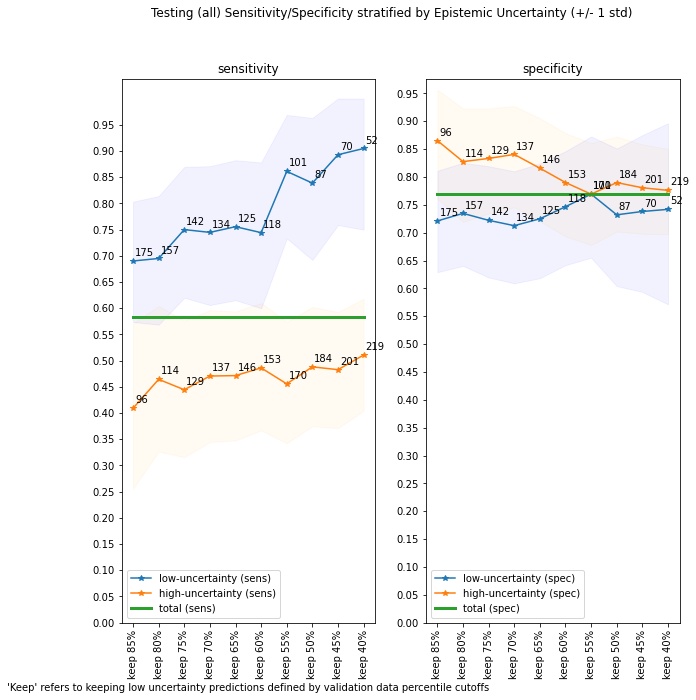

In [15]:
print('test total data')

dict_

total_eval_dict = {x: {} for x in cut_range}


for c in cut_range:
    high_uncertainty_df = None
    low_uncertainty_df = None
    
    low_sens_cut = []
    low_spec_cut = []
    
    high_sens_cut = []
    high_spec_cut = []
    
    for m in range(5):
        if m == 0:
            high_uncertainty_df = dict_['all'][f"model_{m}"][f"c_{c}"]['h_uncert_df']
            low_uncertainty_df = dict_['all'][f"model_{m}"][f"c_{c}"]['l_uncert_df']
            
            specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final'])
            low_sens_cut.append(sensitivity)
            low_spec_cut.append(specificity)
            
            specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final'])
            high_sens_cut.append(sensitivity)
            high_spec_cut.append(specificity)
            
        else:
            high_uncertainty_df = pd.concat([high_uncertainty_df, dict_['all'][f"model_{m}"][f"c_{c}"]['h_uncert_df']])
            low_uncertainty_df = pd.concat([low_uncertainty_df, dict_['all'][f"model_{m}"][f"c_{c}"]['l_uncert_df']])
            
            specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final'])
            low_sens_cut.append(sensitivity)
            low_spec_cut.append(specificity)
            
            specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final'])
            high_sens_cut.append(sensitivity)
            high_spec_cut.append(specificity)

        
    total_eval_dict[c]['total_df'] = pd.concat([high_uncertainty_df, low_uncertainty_df])   
    total_eval_dict[c]['high_uncertainty_df'] = high_uncertainty_df
    total_eval_dict[c]['high_uncertainty_num'] = np.shape(high_uncertainty_df)[0]

    total_eval_dict[c]['low_uncertainty_df'] = low_uncertainty_df
    total_eval_dict[c]['low_uncertainty_num'] = np.shape(low_uncertainty_df)[0]
    
    
    total_eval_dict[c]['fold_l_sens'] = low_sens_cut
    total_eval_dict[c]['fold_h_sens'] = high_sens_cut
    total_eval_dict[c]['fold_l_spec'] = low_spec_cut
    total_eval_dict[c]['fold_h_spec'] = high_spec_cut
    

    total_eval_dict[c]['l_sens_std'] = np.std(total_eval_dict[c]['fold_l_sens'])
    total_eval_dict[c]['h_sens_std'] = np.std(total_eval_dict[c]['fold_h_sens'])
    
    total_eval_dict[c]['l_spec_std'] = np.std(total_eval_dict[c]['fold_l_spec'])
    total_eval_dict[c]['h_spec_std'] = np.std(total_eval_dict[c]['fold_h_spec'])
    
    # confidence interval
    if bootstrap_:
        low_stats_dict = bootstrap_outcome(low_uncertainty_df, n_iter=9999, size=0.90, conf_int=conf_int)
        total_eval_dict[c]['l_sens_conf'] = low_stats_dict['sensitivity']
        total_eval_dict[c]['l_spec_conf'] = low_stats_dict['specificity']

        high_stats_dict = bootstrap_outcome(high_uncertainty_df, n_iter=9999, size=0.90, conf_int=conf_int)
        total_eval_dict[c]['h_sens_conf'] = high_stats_dict['sensitivity']
        total_eval_dict[c]['h_spec_conf'] = high_stats_dict['specificity']
    ###
    

    specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true= total_eval_dict[c]['total_df']['true'], y_pred=total_eval_dict[c]['total_df']['pred_final'])
    total_eval_dict[c]['total_sens'] = sensitivity     
    total_eval_dict[c]['total_spec'] = specificity 

    specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final'])
    total_eval_dict[c]['h_sens'] = sensitivity
    total_eval_dict[c]['h_spec'] = specificity
    
    specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final'])
    total_eval_dict[c]['l_sens'] = sensitivity
    total_eval_dict[c]['l_spec'] = specificity
    
        
cutoff = cut_range
cutoff = cutoff[::-1]
low_uncertainty_num = [total_eval_dict[c]['low_uncertainty_num'] for c in cutoff]
high_uncertainty_num = [total_eval_dict[c]['high_uncertainty_num'] for c in cutoff]

 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))

low_sens = [total_eval_dict[c]['l_sens'] for c in cutoff]

if not bootstrap_:
    print('std')
    low_std_low = [total_eval_dict[c]['l_sens'] - std_num*total_eval_dict[c]['l_sens_std'] for c in cutoff]
    low_std_high = [total_eval_dict[c]['l_sens'] + std_num*total_eval_dict[c]['l_sens_std'] for c in cutoff]
else:
    print('confid')
    low_std_low = [total_eval_dict[c]['l_sens_conf'][0] for c in cutoff]
    low_std_high = [total_eval_dict[c]['l_sens_conf'][1] for c in cutoff]

# low_std_low = [total_eval_dict[c]['l_sens'] - std_num*total_eval_dict[c]['l_sens_std'] for c in cutoff]
# low_std_high = [total_eval_dict[c]['l_sens'] + std_num*total_eval_dict[c]['l_sens_std'] for c in cutoff]

ax1.plot([int(x) for x in cutoff], low_sens, '-*')
ax1.fill_between([int(x) for x in cutoff], (low_std_low), (low_std_high), color='blue', alpha=0.05)

for i, txt in enumerate([str(x) for x in low_uncertainty_num]):
    ax1.annotate(str(txt), ([int(x) for x in cutoff][i], low_sens[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))
    
high_sens = [total_eval_dict[c]['h_sens'] for c in cutoff]

if not bootstrap_:
    print('std')
    high_std_low = [total_eval_dict[c]['h_sens'] - std_num*total_eval_dict[c]['h_sens_std'] for c in cutoff]
    high_std_high = [total_eval_dict[c]['h_sens'] + std_num*total_eval_dict[c]['h_sens_std'] for c in cutoff]
else:
    print('confid')
    high_std_low = [total_eval_dict[c]['h_sens_conf'][0] for c in cutoff]
    high_std_high = [total_eval_dict[c]['h_sens_conf'][1] for c in cutoff]

# high_std_low = [total_eval_dict[c]['h_sens'] - std_num*total_eval_dict[c]['h_sens_std'] for c in cutoff]
# high_std_high = [total_eval_dict[c]['h_sens'] + std_num*total_eval_dict[c]['h_sens_std'] for c in cutoff]

ax1.plot([int(x) for x in cutoff], high_sens, '*-')
ax1.fill_between([int(x) for x in cutoff], (high_std_low), (high_std_high), color='orange', alpha=0.05)

for i, txt in enumerate([str(x) for x in high_uncertainty_num]):
    ax1.annotate(str(txt), ([int(x) for x in cutoff][i], high_sens[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))


ax1.plot([int(x) for x in cutoff], [total_eval_dict[c]['total_sens'] for c in cutoff], linewidth=3)
ax1.legend(['low-uncertainty (sens)', 'high-uncertainty (sens)','total (sens)'], loc='lower left')
ax1.set_title('sensitivity')
ax1.invert_xaxis()
ax1.set_xticks([int(x) for x in cutoff])
ax1.set_xticklabels([f"keep {str(x)}%" for x in cutoff], rotation = 90)
ax1.set_xlabel("'Keep' refers to keeping low uncertainty predictions defined by validation data percentile cutoffs")
ax1.set_yticks(np.arange(0.0, 1, 0.05))

save_dir = r'C:\Users\s185479\Desktop\Python_Code\Projects\Feeding_Tube\uncertainty\uncertainty_update_20220801\save_folder\sens_spec'
f_name = 'test_all_sens.csv'
df = pd.DataFrame([[low_uncertainty_num, low_sens, low_std_low, low_std_high,
                    [total_eval_dict[50]['total_sens'] for x in range(len(low_uncertainty_num))]]], columns=['num', 'l_sens', 'l_sens_low_conf', 'l_sens_high_conf', 'total_sens'])
df.to_csv(os.path.join(save_dir, f_name))

f_name = 'test_all_sens_wrong.csv'
df = pd.DataFrame([[high_uncertainty_num, high_sens, high_std_low, high_std_high,
                    [total_eval_dict[50]['total_sens'] for x in range(len(low_uncertainty_num))]]], columns=['num', 'h_sens', 'h_sens_low_conf', 'h_sens_high_conf', 'total_sens'])
df.to_csv(os.path.join(save_dir, f_name))

# specificity

low_spec = [total_eval_dict[c]['l_spec'] for c in cutoff]

if not bootstrap_:
    print('std')
    low_std_low = [total_eval_dict[c]['l_spec'] - std_num*total_eval_dict[c]['l_spec_std'] for c in cutoff]
    low_std_high = [total_eval_dict[c]['l_spec'] + std_num*total_eval_dict[c]['l_spec_std'] for c in cutoff]
else:
    print('confid')
    low_std_low = [total_eval_dict[c]['l_spec_conf'][0] for c in cutoff]
    low_std_high = [total_eval_dict[c]['l_spec_conf'][1] for c in cutoff]

# low_std_low = [total_eval_dict[c]['l_spec'] - std_num*total_eval_dict[c]['l_spec_std'] for c in cutoff]
# low_std_high = [total_eval_dict[c]['l_spec'] + std_num*total_eval_dict[c]['l_spec_std'] for c in cutoff]

ax2.plot([int(x) for x in cutoff], low_spec, '-*')
ax2.fill_between([int(x) for x in cutoff], (low_std_low), (low_std_high), color='blue', alpha=0.05)

for i, txt in enumerate([str(x) for x in low_uncertainty_num]):
    ax2.annotate(str(txt), ([int(x) for x in cutoff][i], low_spec[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))
    
high_spec = [total_eval_dict[c]['h_spec'] for c in cutoff]

if not bootstrap_:
    print('std')
    high_std_low = [total_eval_dict[c]['h_spec'] - std_num*total_eval_dict[c]['h_spec_std'] for c in cutoff]
    high_std_high = [total_eval_dict[c]['h_spec'] + std_num*total_eval_dict[c]['h_spec_std'] for c in cutoff]
else:
    print('confid')
    high_std_low = [total_eval_dict[c]['h_spec_conf'][0] for c in cutoff]
    high_std_high = [total_eval_dict[c]['h_spec_conf'][1] for c in cutoff]

# high_std_low = [total_eval_dict[c]['h_spec'] - std_num*total_eval_dict[c]['h_spec_std'] for c in cutoff]
# high_std_high = [total_eval_dict[c]['h_spec'] + std_num*total_eval_dict[c]['h_spec_std'] for c in cutoff]

ax2.plot([int(x) for x in cutoff], high_spec, '*-')
ax2.fill_between([int(x) for x in cutoff], (high_std_low), (high_std_high), color='orange', alpha=0.05)

for i, txt in enumerate([str(x) for x in high_uncertainty_num]):
    ax2.annotate(str(txt), ([int(x) for x in cutoff][i], high_spec[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))


ax2.plot([int(x) for x in cutoff], [total_eval_dict[c]['total_spec'] for c in cutoff], linewidth=3)
ax2.legend(['low-uncertainty (spec)', 'high-uncertainty (spec)','total (spec)'], loc='lower left')
ax2.set_yticks(np.arange(0.0, 1, 0.05))
ax2.invert_xaxis()
ax2.set_xticks([int(x) for x in cutoff])
ax2.set_xticklabels([f"keep {str(x)}%" for x in cutoff], rotation = 90)
ax2.set_title('specificity')
fig.suptitle(f"Testing (all) Sensitivity/Specificity stratified by Epistemic Uncertainty (+/- {std_num} std)")

plt.show()

save_dir = r'C:\Users\s185479\Desktop\Python_Code\Projects\Feeding_Tube\uncertainty\uncertainty_update_20220801\save_folder\sens_spec'
f_name = 'test_all_spec.csv'
df = pd.DataFrame([[low_uncertainty_num, low_spec, low_std_low, low_std_high,
                    [total_eval_dict[50]['total_spec'] for x in range(len(low_uncertainty_num))]]], columns=['num', 'l_spec', 'l_spec_low_conf', 'l_spec_high_conf', 'total_spec'])
df.to_csv(os.path.join(save_dir, f_name))

f_name = 'test_all_spec_wrong.csv'
df = pd.DataFrame([[high_uncertainty_num, high_spec, high_std_low, high_std_high,
                    [total_eval_dict[50]['total_spec'] for x in range(len(low_uncertainty_num))]]], columns=['num', 'h_spec', 'h_spec_low_conf', 'h_spec_high_conf', 'total_spec'])
df.to_csv(os.path.join(save_dir, f_name))

val total data - ppv/npv
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
confid
confid
confid
confid


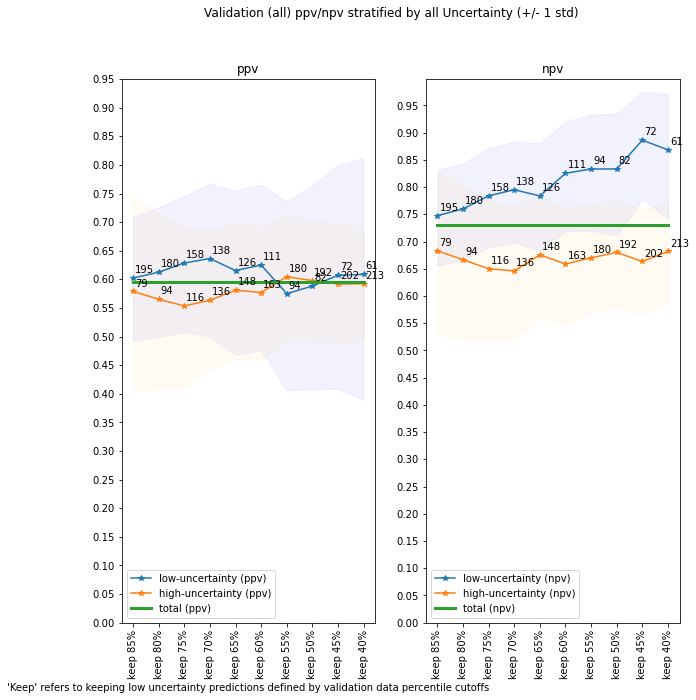

In [16]:
print('val total data - ppv/npv')

dict_val

total_eval_dict = {x: {} for x in cut_range}


for c in cut_range:
    high_uncertainty_df = None
    low_uncertainty_df = None
    
    low_ppv_cut = []
    low_npv_cut = []
    
    high_ppv_cut = []
    high_npv_cut = []
    
    for m in range(5):
        if m == 0:
            high_uncertainty_df = dict_val['all'][f"model_{m}"][f"c_{c}"]['h_uncert_df']
            low_uncertainty_df = dict_val['all'][f"model_{m}"][f"c_{c}"]['l_uncert_df']
            
            specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final'])
            low_ppv_cut.append(ppv)
            low_npv_cut.append(npv)
            
            specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final'])
            high_ppv_cut.append(ppv)
            high_npv_cut.append(npv)
            
        else:
            high_uncertainty_df = pd.concat([high_uncertainty_df, dict_val['all'][f"model_{m}"][f"c_{c}"]['h_uncert_df']])
            low_uncertainty_df = pd.concat([low_uncertainty_df, dict_val['all'][f"model_{m}"][f"c_{c}"]['l_uncert_df']])
            
            specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final'])
            low_ppv_cut.append(ppv)
            low_npv_cut.append(npv)
            
            specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final'])
            high_ppv_cut.append(ppv)
            high_npv_cut.append(npv)

        
    total_eval_dict[c]['total_df'] = pd.concat([high_uncertainty_df, low_uncertainty_df])   
    total_eval_dict[c]['high_uncertainty_df'] = high_uncertainty_df
    total_eval_dict[c]['high_uncertainty_num'] = np.shape(high_uncertainty_df)[0]

    total_eval_dict[c]['low_uncertainty_df'] = low_uncertainty_df
    total_eval_dict[c]['low_uncertainty_num'] = np.shape(low_uncertainty_df)[0]
    
    
    total_eval_dict[c]['fold_l_ppv'] = low_ppv_cut
    total_eval_dict[c]['fold_h_ppv'] = high_ppv_cut
    total_eval_dict[c]['fold_l_npv'] = low_npv_cut
    total_eval_dict[c]['fold_h_npv'] = high_npv_cut
    

    total_eval_dict[c]['l_ppv_std'] = np.std(total_eval_dict[c]['fold_l_ppv'])
    total_eval_dict[c]['h_ppv_std'] = np.std(total_eval_dict[c]['fold_h_ppv'])
    
    total_eval_dict[c]['l_npv_std'] = np.std(total_eval_dict[c]['fold_l_npv'])
    total_eval_dict[c]['h_npv_std'] = np.std(total_eval_dict[c]['fold_h_npv'])
    
    # confidence interval
    if bootstrap_:
        low_stats_dict = bootstrap_outcome(low_uncertainty_df, n_iter=9999, size=0.90, conf_int=conf_int)
        total_eval_dict[c]['l_ppv_conf'] = low_stats_dict['ppv']
        total_eval_dict[c]['l_npv_conf'] = low_stats_dict['npv']

        high_stats_dict = bootstrap_outcome(high_uncertainty_df, n_iter=9999, size=0.90, conf_int=conf_int)
        total_eval_dict[c]['h_ppv_conf'] = high_stats_dict['ppv']
        total_eval_dict[c]['h_npv_conf'] = high_stats_dict['npv']
    ###
    

    specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true= total_eval_dict[c]['total_df']['true'], y_pred=total_eval_dict[c]['total_df']['pred_final'])
    total_eval_dict[c]['total_ppv'] = ppv     
    total_eval_dict[c]['total_npv'] = npv 

    specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final'])
    total_eval_dict[c]['h_ppv'] = ppv
    total_eval_dict[c]['h_npv'] = npv
    
    specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final'])
    total_eval_dict[c]['l_ppv'] = ppv
    total_eval_dict[c]['l_npv'] = npv
    
        
cutoff = cut_range
cutoff = cutoff[::-1]
low_uncertainty_num = [total_eval_dict[c]['low_uncertainty_num'] for c in cutoff]
high_uncertainty_num = [total_eval_dict[c]['high_uncertainty_num'] for c in cutoff]

 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))

low_ppv = [total_eval_dict[c]['l_ppv'] for c in cutoff]

if not bootstrap_:
    print('std')
    low_std_low = [total_eval_dict[c]['l_ppv'] - std_num*total_eval_dict[c]['l_ppv_std'] for c in cutoff]
    low_std_high = [total_eval_dict[c]['l_ppv'] + std_num*total_eval_dict[c]['l_ppv_std'] for c in cutoff]
else:
    print('confid')
    low_std_low = [total_eval_dict[c]['l_ppv_conf'][0] for c in cutoff]
    low_std_high = [total_eval_dict[c]['l_ppv_conf'][1] for c in cutoff]

# low_std_low = [total_eval_dict[c]['l_ppv'] - std_num*total_eval_dict[c]['l_ppv_std'] for c in cutoff]
# low_std_high = [total_eval_dict[c]['l_ppv'] + std_num*total_eval_dict[c]['l_ppv_std'] for c in cutoff]

ax1.plot([int(x) for x in cutoff], low_ppv, '-*')
ax1.fill_between([int(x) for x in cutoff], (low_std_low), (low_std_high), color='blue', alpha=0.05)

for i, txt in enumerate([str(x) for x in low_uncertainty_num]):
    ax1.annotate(str(txt), ([int(x) for x in cutoff][i], low_ppv[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))
    
high_ppv = [total_eval_dict[c]['h_ppv'] for c in cutoff]

if not bootstrap_:
    print('std')
    high_std_low = [total_eval_dict[c]['h_ppv'] - std_num*total_eval_dict[c]['h_ppv_std'] for c in cutoff]
    high_std_high = [total_eval_dict[c]['h_ppv'] + std_num*total_eval_dict[c]['h_ppv_std'] for c in cutoff]
else:
    print('confid')
    high_std_low = [total_eval_dict[c]['h_ppv_conf'][0] for c in cutoff]
    high_std_high = [total_eval_dict[c]['h_ppv_conf'][1] for c in cutoff]

# high_std_low = [total_eval_dict[c]['h_ppv'] - std_num*total_eval_dict[c]['h_ppv_std'] for c in cutoff]
# high_std_high = [total_eval_dict[c]['h_ppv'] + std_num*total_eval_dict[c]['h_ppv_std'] for c in cutoff]

ax1.plot([int(x) for x in cutoff], high_ppv, '*-')
ax1.fill_between([int(x) for x in cutoff], (high_std_low), (high_std_high), color='orange', alpha=0.05)

for i, txt in enumerate([str(x) for x in high_uncertainty_num]):
    ax1.annotate(str(txt), ([int(x) for x in cutoff][i], high_ppv[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))


ax1.plot([int(x) for x in cutoff], [total_eval_dict[c]['total_ppv'] for c in cutoff], linewidth=3)
ax1.legend(['low-uncertainty (ppv)', 'high-uncertainty (ppv)','total (ppv)'], loc='lower left')
ax1.set_title('ppv')
ax1.invert_xaxis()
ax1.set_xticks([int(x) for x in cutoff])
ax1.set_xticklabels([f"keep {str(x)}%" for x in cutoff], rotation = 90)
ax1.set_xlabel("'Keep' refers to keeping low uncertainty predictions defined by validation data percentile cutoffs")
ax1.set_yticks(np.arange(0.0, 1, 0.05))

save_dir = r'C:\Users\s185479\Desktop\Python_Code\Projects\Feeding_Tube\uncertainty\uncertainty_update_20220801\save_folder\sens_spec'
f_name = 'val_all_ppv.csv'
df = pd.DataFrame([[low_uncertainty_num, low_ppv, low_std_low, low_std_high,
                    [total_eval_dict[50]['total_ppv'] for x in range(len(low_uncertainty_num))]]], columns=['num', 'l_ppv', 'l_ppv_low_conf', 'l_ppv_high_conf', 'total_ppv'])
df.to_csv(os.path.join(save_dir, f_name))

f_name = 'val_all_ppv_wrong.csv'
df = pd.DataFrame([[high_uncertainty_num, high_ppv, high_std_low, high_std_high,
                    [total_eval_dict[50]['total_ppv'] for x in range(len(low_uncertainty_num))]]], columns=['num', 'h_ppv', 'h_ppv_low_conf', 'h_ppv_high_conf', 'total_ppv'])
df.to_csv(os.path.join(save_dir, f_name))

# npv

low_npv = [total_eval_dict[c]['l_npv'] for c in cutoff]

if not bootstrap_:
    print('std')
    low_std_low = [total_eval_dict[c]['l_npv'] - std_num*total_eval_dict[c]['l_npv_std'] for c in cutoff]
    low_std_high = [total_eval_dict[c]['l_npv'] + std_num*total_eval_dict[c]['l_npv_std'] for c in cutoff]
else:
    print('confid')
    low_std_low = [total_eval_dict[c]['l_npv_conf'][0] for c in cutoff]
    low_std_high = [total_eval_dict[c]['l_npv_conf'][1] for c in cutoff]

# low_std_low = [total_eval_dict[c]['l_npv'] - std_num*total_eval_dict[c]['l_npv_std'] for c in cutoff]
# low_std_high = [total_eval_dict[c]['l_npv'] + std_num*total_eval_dict[c]['l_npv_std'] for c in cutoff]

ax2.plot([int(x) for x in cutoff], low_npv, '-*')
ax2.fill_between([int(x) for x in cutoff], (low_std_low), (low_std_high), color='blue', alpha=0.05)

for i, txt in enumerate([str(x) for x in low_uncertainty_num]):
    ax2.annotate(str(txt), ([int(x) for x in cutoff][i], low_npv[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))
    
high_npv = [total_eval_dict[c]['h_npv'] for c in cutoff]

if not bootstrap_:
    print('std')
    high_std_low = [total_eval_dict[c]['h_npv'] - std_num*total_eval_dict[c]['h_npv_std'] for c in cutoff]
    high_std_high = [total_eval_dict[c]['h_npv'] + std_num*total_eval_dict[c]['h_npv_std'] for c in cutoff]
else:
    print('confid')
    high_std_low = [total_eval_dict[c]['h_npv_conf'][0] for c in cutoff]
    high_std_high = [total_eval_dict[c]['h_npv_conf'][1] for c in cutoff]

# high_std_low = [total_eval_dict[c]['h_npv'] - std_num*total_eval_dict[c]['h_npv_std'] for c in cutoff]
# high_std_high = [total_eval_dict[c]['h_npv'] + std_num*total_eval_dict[c]['h_npv_std'] for c in cutoff]

ax2.plot([int(x) for x in cutoff], high_npv, '*-')
ax2.fill_between([int(x) for x in cutoff], (high_std_low), (high_std_high), color='orange', alpha=0.05)

for i, txt in enumerate([str(x) for x in high_uncertainty_num]):
    ax2.annotate(str(txt), ([int(x) for x in cutoff][i], high_npv[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))


ax2.plot([int(x) for x in cutoff], [total_eval_dict[c]['total_npv'] for c in cutoff], linewidth=3)
ax2.legend(['low-uncertainty (npv)', 'high-uncertainty (npv)','total (npv)'], loc='lower left')
ax2.set_yticks(np.arange(0.0, 1, 0.05))
ax2.invert_xaxis()
ax2.set_xticks([int(x) for x in cutoff])
ax2.set_xticklabels([f"keep {str(x)}%" for x in cutoff], rotation = 90)
ax2.set_title('npv')
fig.suptitle(f"Validation (all) ppv/npv stratified by all Uncertainty (+/- {std_num} std)")

plt.show()

save_dir = r'C:\Users\s185479\Desktop\Python_Code\Projects\Feeding_Tube\uncertainty\uncertainty_update_20220801\save_folder\sens_spec'
f_name = 'val_all_npv.csv'
df = pd.DataFrame([[low_uncertainty_num, low_npv, low_std_low, low_std_high,
                    [total_eval_dict[50]['total_npv'] for x in range(len(low_uncertainty_num))]]], columns=['num', 'l_npv', 'l_npv_low_conf', 'l_npv_high_conf', 'total_npv'])
df.to_csv(os.path.join(save_dir, f_name))

f_name = 'val_all_npv_wrong.csv'
df = pd.DataFrame([[high_uncertainty_num, high_npv, high_std_low, high_std_high,
                    [total_eval_dict[50]['total_npv'] for x in range(len(low_uncertainty_num))]]], columns=['num', 'h_npv', 'h_npv_low_conf', 'h_npv_high_conf', 'total_npv'])
df.to_csv(os.path.join(save_dir, f_name))

test total data - ppv
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
PERFORMING BOOTSTRAP
confid
confid
confid
confid


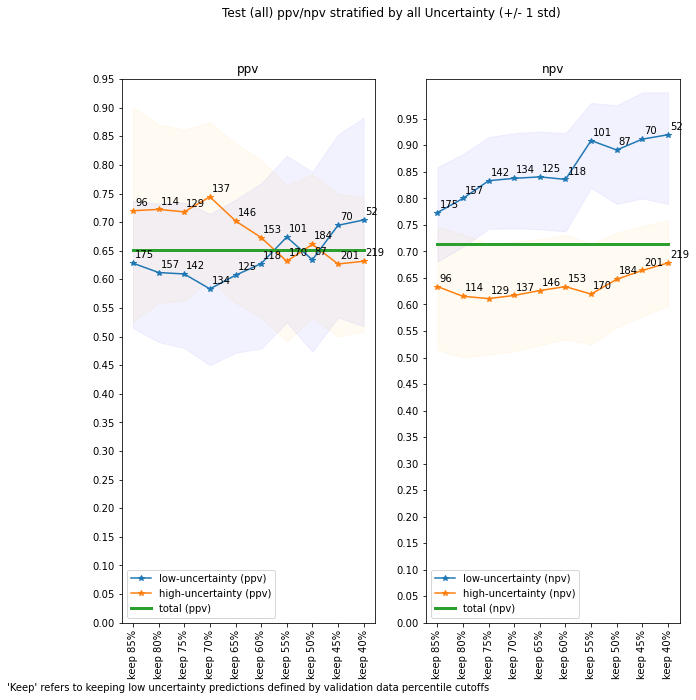

In [17]:
print('test total data - ppv')

dict_

total_eval_dict = {x: {} for x in cut_range}


for c in cut_range:
    high_uncertainty_df = None
    low_uncertainty_df = None
    
    low_ppv_cut = []
    low_npv_cut = []
    
    high_ppv_cut = []
    high_npv_cut = []
    
    for m in range(5):
        if m == 0:
            high_uncertainty_df = dict_['all'][f"model_{m}"][f"c_{c}"]['h_uncert_df']
            low_uncertainty_df = dict_['all'][f"model_{m}"][f"c_{c}"]['l_uncert_df']
            
            specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final'])
            low_ppv_cut.append(ppv)
            low_npv_cut.append(npv)
            
            specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final'])
            high_ppv_cut.append(ppv)
            high_npv_cut.append(npv)
            
        else:
            high_uncertainty_df = pd.concat([high_uncertainty_df, dict_['all'][f"model_{m}"][f"c_{c}"]['h_uncert_df']])
            low_uncertainty_df = pd.concat([low_uncertainty_df, dict_['all'][f"model_{m}"][f"c_{c}"]['l_uncert_df']])
            
            specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final'])
            low_ppv_cut.append(ppv)
            low_npv_cut.append(npv)
            
            specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final'])
            high_ppv_cut.append(ppv)
            high_npv_cut.append(npv)

        
    total_eval_dict[c]['total_df'] = pd.concat([high_uncertainty_df, low_uncertainty_df])   
    total_eval_dict[c]['high_uncertainty_df'] = high_uncertainty_df
    total_eval_dict[c]['high_uncertainty_num'] = np.shape(high_uncertainty_df)[0]

    total_eval_dict[c]['low_uncertainty_df'] = low_uncertainty_df
    total_eval_dict[c]['low_uncertainty_num'] = np.shape(low_uncertainty_df)[0]
    
    
    total_eval_dict[c]['fold_l_ppv'] = low_ppv_cut
    total_eval_dict[c]['fold_h_ppv'] = high_ppv_cut
    total_eval_dict[c]['fold_l_npv'] = low_npv_cut
    total_eval_dict[c]['fold_h_npv'] = high_npv_cut
    

    total_eval_dict[c]['l_ppv_std'] = np.std(total_eval_dict[c]['fold_l_ppv'])
    total_eval_dict[c]['h_ppv_std'] = np.std(total_eval_dict[c]['fold_h_ppv'])
    
    total_eval_dict[c]['l_npv_std'] = np.std(total_eval_dict[c]['fold_l_npv'])
    total_eval_dict[c]['h_npv_std'] = np.std(total_eval_dict[c]['fold_h_npv'])
    
    # confidence interval
    if bootstrap_:
        low_stats_dict = bootstrap_outcome(low_uncertainty_df, n_iter=9999, size=0.90, conf_int=conf_int)
        total_eval_dict[c]['l_ppv_conf'] = low_stats_dict['ppv']
        total_eval_dict[c]['l_npv_conf'] = low_stats_dict['npv']

        high_stats_dict = bootstrap_outcome(high_uncertainty_df, n_iter=9999, size=0.90, conf_int=conf_int)
        total_eval_dict[c]['h_ppv_conf'] = high_stats_dict['ppv']
        total_eval_dict[c]['h_npv_conf'] = high_stats_dict['npv']
    ###
    

    specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true= total_eval_dict[c]['total_df']['true'], y_pred=total_eval_dict[c]['total_df']['pred_final'])
    total_eval_dict[c]['total_ppv'] = ppv     
    total_eval_dict[c]['total_npv'] = npv 

    specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=high_uncertainty_df['true'], y_pred=high_uncertainty_df['pred_final'])
    total_eval_dict[c]['h_ppv'] = ppv
    total_eval_dict[c]['h_npv'] = npv
    
    specificity, sensitivity, ppv, npv = dr_friendly_measures(y_true=low_uncertainty_df['true'], y_pred=low_uncertainty_df['pred_final'])
    total_eval_dict[c]['l_ppv'] = ppv
    total_eval_dict[c]['l_npv'] = npv
    
        
cutoff = cut_range
cutoff = cutoff[::-1]
low_uncertainty_num = [total_eval_dict[c]['low_uncertainty_num'] for c in cutoff]
high_uncertainty_num = [total_eval_dict[c]['high_uncertainty_num'] for c in cutoff]

 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))

low_ppv = [total_eval_dict[c]['l_ppv'] for c in cutoff]
if not bootstrap_:
    print('std')
    low_std_low = [total_eval_dict[c]['l_ppv'] - std_num*total_eval_dict[c]['l_ppv_std'] for c in cutoff]
    low_std_high = [total_eval_dict[c]['l_ppv'] + std_num*total_eval_dict[c]['l_ppv_std'] for c in cutoff]
else:
    print('confid')
    low_std_low = [total_eval_dict[c]['l_ppv_conf'][0] for c in cutoff]
    low_std_high = [total_eval_dict[c]['l_ppv_conf'][1] for c in cutoff]

# low_std_low = [total_eval_dict[c]['l_ppv'] - std_num*total_eval_dict[c]['l_ppv_std'] for c in cutoff]
# low_std_high = [total_eval_dict[c]['l_ppv'] + std_num*total_eval_dict[c]['l_ppv_std'] for c in cutoff]

ax1.plot([int(x) for x in cutoff], low_ppv, '-*')
ax1.fill_between([int(x) for x in cutoff], (low_std_low), (low_std_high), color='blue', alpha=0.05)

for i, txt in enumerate([str(x) for x in low_uncertainty_num]):
    ax1.annotate(str(txt), ([int(x) for x in cutoff][i], low_ppv[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))
    
high_ppv = [total_eval_dict[c]['h_ppv'] for c in cutoff]

if not bootstrap_:
    print('std')
    high_std_low = [total_eval_dict[c]['h_ppv'] - std_num*total_eval_dict[c]['h_ppv_std'] for c in cutoff]
    high_std_high = [total_eval_dict[c]['h_ppv'] + std_num*total_eval_dict[c]['h_ppv_std'] for c in cutoff]
else:
    print('confid')
    high_std_low = [total_eval_dict[c]['h_ppv_conf'][0] for c in cutoff]
    high_std_high = [total_eval_dict[c]['h_ppv_conf'][1] for c in cutoff]

# high_std_low = [total_eval_dict[c]['h_ppv'] - std_num*total_eval_dict[c]['h_ppv_std'] for c in cutoff]
# high_std_high = [total_eval_dict[c]['h_ppv'] + std_num*total_eval_dict[c]['h_ppv_std'] for c in cutoff]

ax1.plot([int(x) for x in cutoff], high_ppv, '*-')
ax1.fill_between([int(x) for x in cutoff], (high_std_low), (high_std_high), color='orange', alpha=0.05)

for i, txt in enumerate([str(x) for x in high_uncertainty_num]):
    ax1.annotate(str(txt), ([int(x) for x in cutoff][i], high_ppv[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))


ax1.plot([int(x) for x in cutoff], [total_eval_dict[c]['total_ppv'] for c in cutoff], linewidth=3)
ax1.legend(['low-uncertainty (ppv)', 'high-uncertainty (ppv)','total (ppv)'], loc='lower left')
ax1.set_title('ppv')
ax1.invert_xaxis()
ax1.set_xticks([int(x) for x in cutoff])
ax1.set_xticklabels([f"keep {str(x)}%" for x in cutoff], rotation = 90)
ax1.set_xlabel("'Keep' refers to keeping low uncertainty predictions defined by validation data percentile cutoffs")
ax1.set_yticks(np.arange(0.0, 1, 0.05))

save_dir = r'C:\Users\s185479\Desktop\Python_Code\Projects\Feeding_Tube\uncertainty\uncertainty_update_20220801\save_folder\sens_spec'
f_name = 'test_all_ppv.csv'
df = pd.DataFrame([[low_uncertainty_num, low_ppv, low_std_low, low_std_high,
                    [total_eval_dict[50]['total_ppv'] for x in range(len(low_uncertainty_num))]]], columns=['num', 'l_ppv', 'l_ppv_low_conf', 'l_ppv_high_conf', 'total_ppv'])
df.to_csv(os.path.join(save_dir, f_name))

f_name = 'test_all_ppv_wrong.csv'
df = pd.DataFrame([[high_uncertainty_num, high_ppv, high_std_low, high_std_high,
                    [total_eval_dict[50]['total_ppv'] for x in range(len(low_uncertainty_num))]]], columns=['num', 'h_ppv', 'h_ppv_low_conf', 'h_ppv_high_conf', 'total_ppv'])
df.to_csv(os.path.join(save_dir, f_name))

# npv

low_npv = [total_eval_dict[c]['l_npv'] for c in cutoff]

if not bootstrap_:
    print('std')
    low_std_low = [total_eval_dict[c]['l_npv'] - std_num*total_eval_dict[c]['l_npv_std'] for c in cutoff]
    low_std_high = [total_eval_dict[c]['l_npv'] + std_num*total_eval_dict[c]['l_npv_std'] for c in cutoff]
else:
    print('confid')
    low_std_low = [total_eval_dict[c]['l_npv_conf'][0] for c in cutoff]
    low_std_high = [total_eval_dict[c]['l_npv_conf'][1] for c in cutoff]

# low_std_low = [total_eval_dict[c]['l_npv'] - std_num*total_eval_dict[c]['l_npv_std'] for c in cutoff]
# low_std_high = [total_eval_dict[c]['l_npv'] + std_num*total_eval_dict[c]['l_npv_std'] for c in cutoff]

ax2.plot([int(x) for x in cutoff], low_npv, '-*')
ax2.fill_between([int(x) for x in cutoff], (low_std_low), (low_std_high), color='blue', alpha=0.05)

for i, txt in enumerate([str(x) for x in low_uncertainty_num]):
    ax2.annotate(str(txt), ([int(x) for x in cutoff][i], low_npv[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))
    
high_npv = [total_eval_dict[c]['h_npv'] for c in cutoff]

if not bootstrap_:
    print('std')
    high_std_low = [total_eval_dict[c]['h_npv'] - std_num*total_eval_dict[c]['h_npv_std'] for c in cutoff]
    high_std_high = [total_eval_dict[c]['h_npv'] + std_num*total_eval_dict[c]['h_npv_std'] for c in cutoff]
else:
    print('confid')
    high_std_low = [total_eval_dict[c]['h_npv_conf'][0] for c in cutoff]
    high_std_high = [total_eval_dict[c]['h_npv_conf'][1] for c in cutoff]

# high_std_low = [total_eval_dict[c]['h_npv'] - std_num*total_eval_dict[c]['h_npv_std'] for c in cutoff]
# high_std_high = [total_eval_dict[c]['h_npv'] + std_num*total_eval_dict[c]['h_npv_std'] for c in cutoff]

ax2.plot([int(x) for x in cutoff], high_npv, '*-')
ax2.fill_between([int(x) for x in cutoff], (high_std_low), (high_std_high), color='orange', alpha=0.05)

for i, txt in enumerate([str(x) for x in high_uncertainty_num]):
    ax2.annotate(str(txt), ([int(x) for x in cutoff][i], high_npv[i]), 
                 xycoords='data', textcoords='offset points', xytext=(2, 5))


ax2.plot([int(x) for x in cutoff], [total_eval_dict[c]['total_npv'] for c in cutoff], linewidth=3)
ax2.legend(['low-uncertainty (npv)', 'high-uncertainty (npv)','total (npv)'], loc='lower left')
ax2.set_yticks(np.arange(0.0, 1, 0.05))
ax2.invert_xaxis()
ax2.set_xticks([int(x) for x in cutoff])
ax2.set_xticklabels([f"keep {str(x)}%" for x in cutoff], rotation = 90)
ax2.set_title('npv')
fig.suptitle(f"Test (all) ppv/npv stratified by all Uncertainty (+/- {std_num} std)")

plt.show()

save_dir = r'C:\Users\s185479\Desktop\Python_Code\Projects\Feeding_Tube\uncertainty\uncertainty_update_20220801\save_folder\sens_spec'
f_name = 'test_all_npv.csv'
df = pd.DataFrame([[low_uncertainty_num, low_npv, low_std_low, low_std_high,
                    [total_eval_dict[50]['total_npv'] for x in range(len(low_uncertainty_num))]]], columns=['num', 'l_npv', 'l_npv_low_conf', 'l_npv_high_conf', 'total_npv'])
df.to_csv(os.path.join(save_dir, f_name))

f_name = 'test_all_npv_wrong.csv'
df = pd.DataFrame([[high_uncertainty_num, high_npv, high_std_low, high_std_high,
                    [total_eval_dict[50]['total_npv'] for x in range(len(low_uncertainty_num))]]], columns=['num', 'h_npv', 'h_npv_low_conf', 'h_npv_high_conf', 'total_npv'])
df.to_csv(os.path.join(save_dir, f_name))